## <p style="background-color:#FDFEFE; font-family:newtimeroman; color:#060108; font-size:200%; text-align:center; border-radius:10px 10px;"> ML Clustering Capstone Project</p>

## <p style="background-color:#FDFEFE; font-family:newtimeroman; color:#060108; font-size:150%; text-align:center; border-radius:10px 10px;">RFM Customer Segmentation & Cohort Analysis</p>

## <p style="background-color:#FDFEFE; font-family:newtimeroman; color:#060108; font-size:100%; text-align:center; border-radius:10px 10px;">Tayfun Kok </p>

<img src=https://miro.medium.com/max/1400/1*fIdNbG1ZRM9JIitNkTJEfA.png width="800" height="200">

<a id="74"></a>
## <p style="background-color:#1874CD; font-family:newtimeroman; color:#FFF9ED; font-size:130%; text-align:center; border-radius:10px 10px;">Table of Contents</p>

* [Introduction](#0)
* [Importing Related Libraries](#1)
* [Exploratory Data Analysis (EDA)](#2)
* [RFM Analysis](#3)    
* [Customer Segmentation with RFM Scores](#4)
* [Applying K-Means Clustering](#5)
* [Create Cohort and Conduct Cohort Analysis](#6)
* [Coclusion](#7)

# <p style="background-color:#1874CD; font-family:newtimeroman; color:#FFF9ED; font-size:130%; text-align:center; border-radius:10px 10px;">Introduction</p>
<a id="0"></a>
<a href="#74" class="btn btn-primary btn-sm" role="button" aria-pressed="true" 
style="color:blue; background-color:#dfa8e4" data-toggle="popover">Table of Contents</a>

# <p style="background-color:#1874CD; font-family:newtimeroman; color:#FFF9ED; font-size:130%; text-align:center; border-radius:10px 10px;">Importing Related Libraries</p>

<a id="1"></a>
<a href="#74" class="btn btn-primary btn-sm" role="button" aria-pressed="true" 
style="color:blue; background-color:#dfa8e4" data-toggle="popover">Table of Contents</a>

In [1]:
#!pip install missingno
#!pip install pyforest
#!pip install cufflinks
#!pip install termcolor
#!pip install wordcloud
#!pip install squarify
#!pip install pyclustertend
#!pip install yellowbrick --user

In [2]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
import missingno as msno 

from sklearn.compose import make_column_transformer

# Scaling
from sklearn.preprocessing import scale 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

# Importing plotly and cufflinks in offline mode
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

# Figure&Display options
plt.rcParams["figure.figsize"] = (10,6)
pd.set_option('max_colwidth',200)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 200)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# makes strings colored
import colorama
from colorama import Fore, Style
from termcolor import colored

import ipywidgets
from ipywidgets import interact

# White grid plots for dark mode users
sns.set_style("whitegrid")



# <p style="background-color:#1874CD; font-family:newtimeroman; color:#FFF9ED; font-size:130%; text-align:center; border-radius:10px 10px;">Exploratory Data Analysis</p>

<a id="2"></a>
<a href="#74" class="btn btn-primary btn-sm" role="button" aria-pressed="true" 
style="color:blue; background-color:#dfa8e4" data-toggle="popover">Table of Contents</a>

## User defined functions 

In [3]:
def missing_values(df):
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values[missing_values['Missing_Number']>0]

In [4]:
def first_looking(df):
    print(colored("Shape:", attrs=['bold']), df.shape,'\n', 
          colored('-'*79, 'red', attrs=['bold']),
          colored("\nInfo:\n", attrs=['bold']), sep='')
    print(df.info(), '\n', 
          colored('-'*79, 'red', attrs=['bold']), sep='')
    print(colored("Number of Uniques:\n", attrs=['bold']), df.nunique(),'\n',
          colored('-'*79, 'red', attrs=['bold']), sep='')
    print(colored("Missing Values:\n", attrs=['bold']), missing_values(df),'\n', 
          colored('-'*79, 'red', attrs=['bold']), sep='')
    print(colored("All Columns:", attrs=['bold']), list(df.columns),'\n', 
          colored('-'*79, 'red', attrs=['bold']), sep='')

    df.columns= df.columns.str.lower().str.replace('&', '_').str.replace(' ', '_')

    print(colored("Columns after rename:", attrs=['bold']), list(df.columns),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')
    

In [5]:
def multicolinearity_control(df):
    feature =[]
    collinear=[]
    for col in df.corr().columns:
        for i in df.corr().index:
            if (abs(df.corr()[col][i])> .9 and abs(df.corr()[col][i]) < 1):
                    feature.append(col)
                    collinear.append(i)
                    print(colored(f"Multicolinearity alert in between:{col} - {i}", 
                                  "red", attrs=['bold']), df.shape,'\n',
                                  colored('-'*79, 'red', attrs=['bold']), sep='')

In [6]:
def duplicate_values(df):
    print(colored("Duplicate check...", attrs=['bold']), sep='')
    duplicate_values = df.duplicated(subset=None, keep='first').sum()
    if duplicate_values > 0:
        df.drop_duplicates(keep='first', inplace=True)
        print(duplicate_values, colored("Duplicates were dropped!"),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')
    else:
        print(colored("There are no duplicates"),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')    

In [7]:
def drop_columns(df, drop_columns):
    if drop_columns !=[]:
        df.drop(drop_columns, axis=1, inplace=True)
        print(drop_columns, 'were dropped')
    else:
        print(colored('We will now check the missing values and if necessary will drop realted columns!', attrs=['bold']),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')

In [8]:
def drop_null(df, limit):
    print('Shape:', df.shape)
    for i in df.isnull().sum().index:
        if (df.isnull().sum()[i]/df.shape[0]*100)>limit:
            print(df.isnull().sum()[i], 'percent of', i ,'null and were dropped')
            df.drop(i, axis=1, inplace=True)
            print('new shape:', df.shape)       
    print('New shape after missing value control:', df.shape)

## Importing Dataset

In [9]:
df = pd.read_csv("Online Retail.csv", index_col=0)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365.0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.000,2010-12-01 08:26:00,2.550,17850.000,United Kingdom
1,536365.0,71053.0,WHITE METAL LANTERN,6.000,2010-12-01 08:26:00,3.390,17850.000,United Kingdom
2,536365.0,84406B,CREAM CUPID HEARTS COAT HANGER,8.000,2010-12-01 08:26:00,2.750,17850.000,United Kingdom
3,536365.0,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.000,2010-12-01 08:26:00,3.390,17850.000,United Kingdom
4,536365.0,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.000,2010-12-01 08:26:00,3.390,17850.000,United Kingdom


## Data Review

In [10]:
df.shape

(541909, 8)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  float64
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(3), object(5)
memory usage: 37.2+ MB


**We rename some column names.** 

In [12]:
df.rename(columns={'InvoiceNo':'invoice_no', 'StockCode':'stock_code','Description':'description',
           'Quantity':'quantity','Country':'country', 'InvoiceDate':'invoice_date', 'UnitPrice':'unit_price', 
            'CustomerID':'customer_id'}, inplace=True)

In [13]:
df.columns

Index(['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country'],
      dtype='object')

In [14]:
df.nunique()

invoice_no      25900
stock_code       4070
description      4223
quantity          722
invoice_date    23260
unit_price       1630
customer_id      4372
country            38
dtype: int64

In [15]:
df.isnull().sum().sort_values(ascending=False)

customer_id     135080
description       1454
invoice_no           0
stock_code           0
quantity             0
invoice_date         0
unit_price           0
country              0
dtype: int64

In [16]:
(df.isnull().sum()/df.shape[0]).sort_values(ascending=False)

customer_id    0.249
description    0.003
invoice_no     0.000
stock_code     0.000
quantity       0.000
invoice_date   0.000
unit_price     0.000
country        0.000
dtype: float64

In [17]:
df.duplicated().sum()

5268

In [18]:
df.drop_duplicates(keep='first', inplace=True)

In [19]:
df.shape

(536641, 8)

* Orders which do NOT have customer ID's were not made by the customers already in the dataset because the customers who in fact made some purchases already have ID's. Thus, we will drop NaN values of "customer _id" column 

In [20]:
df = df.dropna(subset=['customer_id'])

In [21]:
df.shape

(401604, 8)

In [22]:
df.isnull().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

In [23]:
df.describe()

,quantity,unit_price,customer_id
count,401604.000,401604.000,401604.000
mean,12.183,3.474,15281.161
std,250.283,69.764,1714.006
min,-80995.000,0.000,12346.000
25%,2.000,1.250,13939.000
50%,5.000,1.950,15145.000
75%,12.000,3.750,16784.000
max,80995.000,38970.000,18287.000


## Take a look at relationships between InvoiceNo, Quantity and UnitPrice columns.

In [24]:
df[["quantity", "unit_price"]].describe()

,quantity,unit_price
count,401604.000,401604.000
mean,12.183,3.474
std,250.283,69.764
min,-80995.000,0.000
25%,2.000,1.250
50%,5.000,1.950
75%,12.000,3.750
max,80995.000,38970.000


In [25]:
df[df['quantity'] < 0].shape

(8872, 8)

In [26]:
df[df['unit_price'] == 0].shape

(40, 8)

In [27]:
df[df['invoice_no'].astype(str).str.startswith('C')]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
141,C536379,D,Discount,-1.000,2010-12-01 09:41:00,27.500,14527.000,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1.000,2010-12-01 09:49:00,4.650,15311.000,United Kingdom
235,C536391,22556.0,PLASTERS IN TIN CIRCUS PARADE,-12.000,2010-12-01 10:24:00,1.650,17548.000,United Kingdom
236,C536391,21984.0,PACK OF 12 PINK PAISLEY TISSUES,-24.000,2010-12-01 10:24:00,0.290,17548.000,United Kingdom
237,C536391,21983.0,PACK OF 12 BLUE PAISLEY TISSUES,-24.000,2010-12-01 10:24:00,0.290,17548.000,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144.0,ZINC T-LIGHT HOLDER STARS SMALL,-11.000,2011-12-09 09:57:00,0.830,14397.000,United Kingdom
541541,C581499,M,Manual,-1.000,2011-12-09 10:28:00,224.690,15498.000,United Kingdom
541715,C581568,21258.0,VICTORIAN SEWING BOX LARGE,-5.000,2011-12-09 11:57:00,10.950,15311.000,United Kingdom
541716,C581569,84978.0,HANGING HEART JAR T-LIGHT HOLDER,-1.000,2011-12-09 11:58:00,1.250,17315.000,United Kingdom


In [28]:
df["invoice_no"].str.startswith('C').value_counts()

False    392732
True       8872
Name: invoice_no, dtype: int64

In [29]:
df["invoice_no"].str.startswith('C').value_counts(normalize=True)*100

False   97.791
True     2.209
Name: invoice_no, dtype: float64

In [30]:
df[df["invoice_no"].str.startswith('C')] [["quantity", "unit_price"]].describe()

,quantity,unit_price
count,8872.000,8872.000
mean,-30.775,18.900
std,1172.250,445.191
min,-80995.000,0.010
25%,-6.000,1.450
50%,-2.000,2.950
75%,-1.000,4.950
max,-1.000,38970.000


**All orders with invoices starting with 'C' have less than zero quantity. This means the orders have been canceled. Thus, we consider only values which of quantity and unit_price are larger than zero.** 

In [31]:
df=df[(df.quantity > 0) & (df.unit_price > 0)]

In [32]:
df.shape

(392692, 8)

## Explore the Orders

**The unique number of InvoiceNo per customer**

In [33]:
df.groupby('customer_id')['invoice_no'].nunique().sort_values(ascending=False)

customer_id
12748.000    209
14911.000    201
17841.000    124
13089.000     97
14606.000     93
            ... 
15314.000      1
15313.000      1
15308.000      1
15307.000      1
15300.000      1
Name: invoice_no, Length: 4338, dtype: int64

**The average number of unique items per order or per customer**

In [34]:
df.groupby(['customer_id', 'stock_code'])['quantity'].mean()

customer_id  stock_code
12346.000    23166.0      74215.000
12347.000    16008.0         24.000
             17021.0         36.000
             20665.0          6.000
             20719.0         10.000
                             ...   
18287.000    84920.0          4.000
             85039A          48.000
             85039B          40.000
             85040A          24.000
             85173.0         48.000
Name: quantity, Length: 266792, dtype: float64

In [35]:
df.groupby(['invoice_no', 'stock_code'])['quantity'].mean()

invoice_no  stock_code
536365.0    21730.0      6.000
            22752.0      2.000
            71053.0      6.000
            84029E       6.000
            84029G       6.000
                          ... 
581587.0    22730.0      4.000
            22899.0      6.000
            23254.0      4.000
            23255.0      4.000
            23256.0      4.000
Name: quantity, Length: 387841, dtype: float64

**Comparing to the number of unique products per customer**

In [36]:
df.groupby(['customer_id', 'stock_code'])['quantity'].sum()

customer_id  stock_code
12346.000    23166.0      74215.000
12347.000    16008.0         24.000
             17021.0         36.000
             20665.0          6.000
             20719.0         40.000
                             ...   
18287.000    84920.0          4.000
             85039A          96.000
             85039B         120.000
             85040A          48.000
             85173.0         48.000
Name: quantity, Length: 266792, dtype: float64

## Explore Customers by Country

**Total revenue per country**

* Revenue means total price.
* Total Price = Quantity X Unit Price

In [37]:
df['total_price'] = df['quantity'] * df['unit_price']

In [38]:
df.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,total_price
0,536365.0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.000,2010-12-01 08:26:00,2.550,17850.000,United Kingdom,15.300
1,536365.0,71053.0,WHITE METAL LANTERN,6.000,2010-12-01 08:26:00,3.390,17850.000,United Kingdom,20.340
2,536365.0,84406B,CREAM CUPID HEARTS COAT HANGER,8.000,2010-12-01 08:26:00,2.750,17850.000,United Kingdom,22.000
3,536365.0,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.000,2010-12-01 08:26:00,3.390,17850.000,United Kingdom,20.340
4,536365.0,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.000,2010-12-01 08:26:00,3.390,17850.000,United Kingdom,20.340


In [39]:
df["country"].value_counts()

United Kingdom          349203
Germany                   9025
France                    8326
EIRE                      7226
Spain                     2479
Netherlands               2359
Belgium                   2031
Switzerland               1841
Portugal                  1453
Australia                 1181
Norway                    1071
Italy                      758
Channel Islands            747
Finland                    685
Cyprus                     603
Sweden                     450
Austria                    398
Denmark                    380
Poland                     330
Japan                      321
Israel                     245
Unspecified                241
Singapore                  222
Iceland                    182
USA                        179
Canada                     151
Greece                     145
Malta                      112
United Arab Emirates        68
European Community          60
RSA                         57
Lebanon                     45
Lithuani

In [40]:
df.groupby('country')[["total_price"]].sum().sort_values(by="total_price", ascending=False)

,total_price
country,
United Kingdom,7285024.644
Netherlands,285446.340
EIRE,265262.460
Germany,228678.400
France,208934.310
Australia,138453.810
Spain,61558.560
Switzerland,56443.950
Belgium,41196.340


**Visualize number of customer per country**

In [41]:
df["customer_id"].nunique()

4338

In [42]:
df.groupby('country')["customer_id"].nunique().sum()

4346

In [43]:
df[df["customer_id"]==12431.0]["country"].value_counts()

Australia    180
Belgium       54
Name: country, dtype: int64

We have 4338 unique "customer_id". But when we are grouping them using with country column; Our unique number of customers is increasing.
It means some "customer_id" (totally 8) are included in multiple country names. For ex: '12431.0'

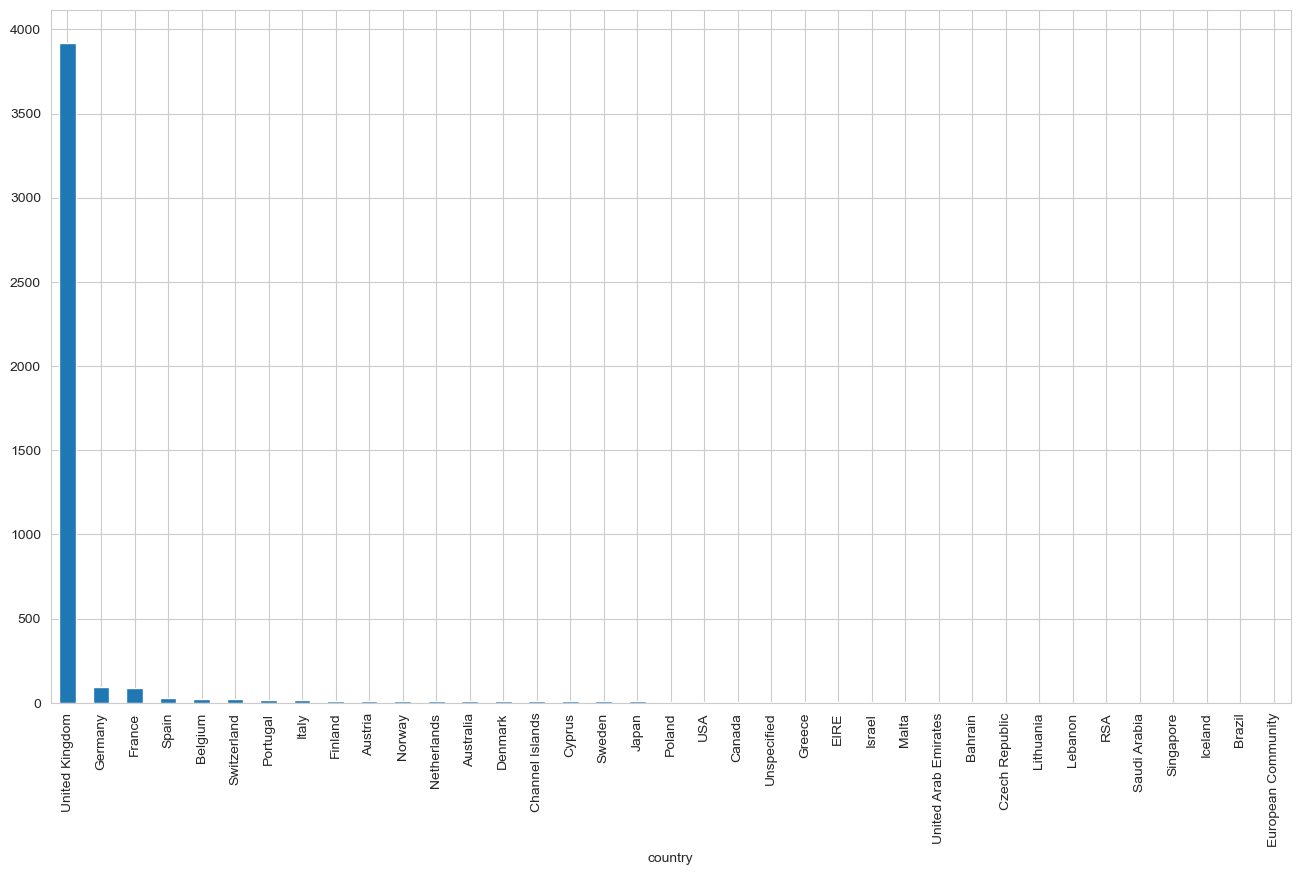

In [44]:
plt.figure(figsize=(16,9))
df.groupby('country')["customer_id"].nunique().sort_values(ascending=False).plot.bar();

**Total unique number of customers graph without United Kingdom**

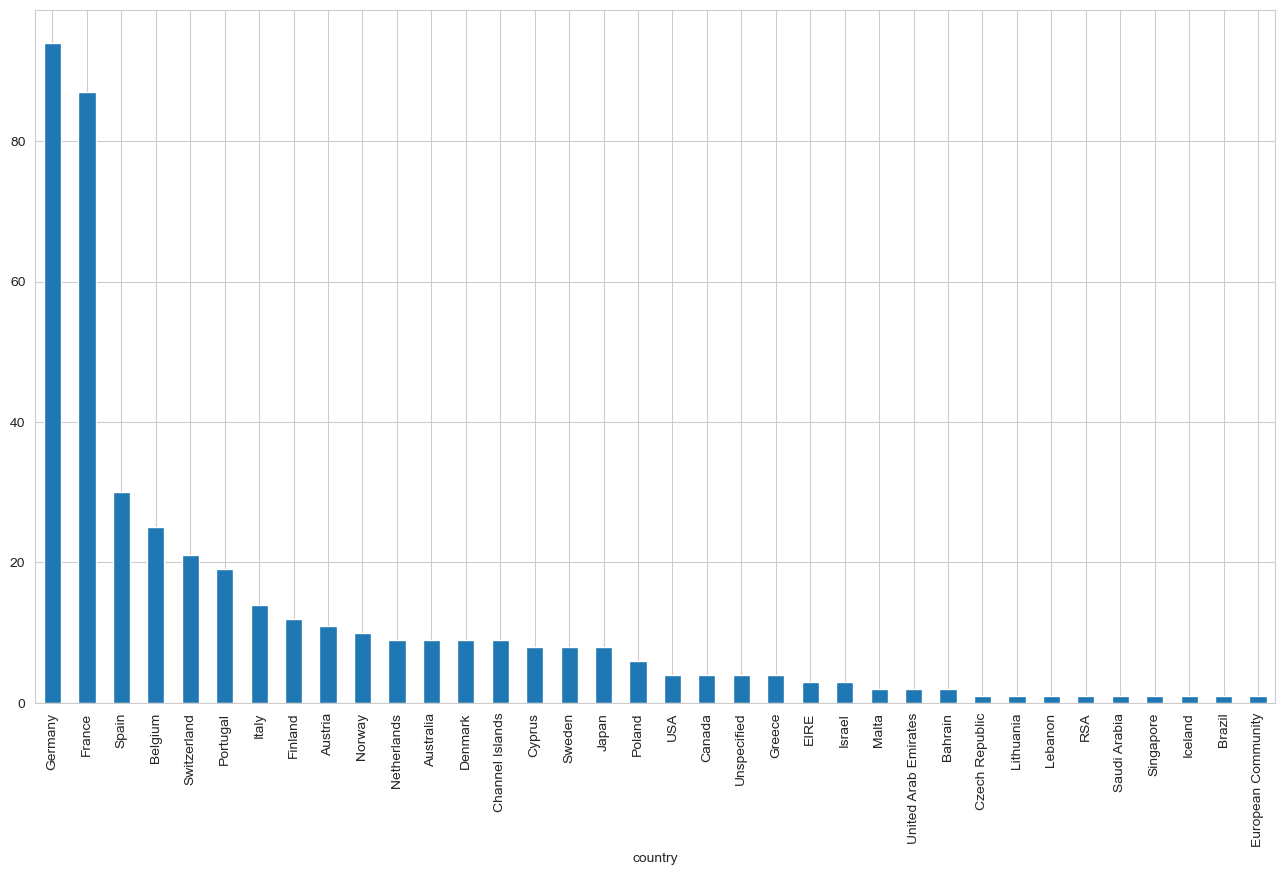

In [45]:
plt.figure(figsize=(16,9))
sns.set_style("whitegrid")
df.groupby('country')["customer_id"].nunique().sort_values(ascending=False).iloc[1:].plot.bar();

**Visualize total cost per country**

In [46]:
df_total_price = pd.DataFrame(df.groupby('country')["total_price"].sum().sort_values(ascending=False))

In [47]:
total=df.groupby('country')["total_price"].sum().sort_values(ascending=False)

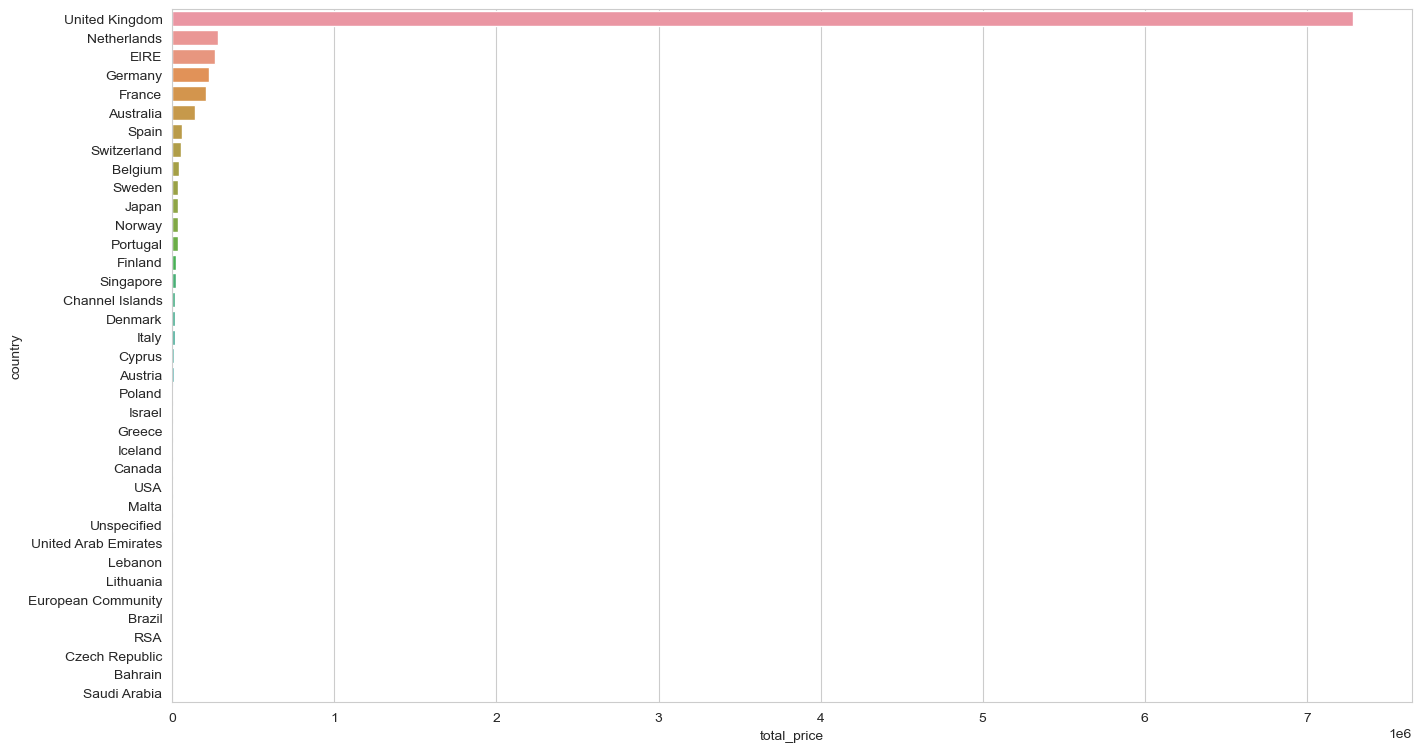

In [48]:
plt.figure(figsize=(16,9))
sns.barplot(data = df_total_price, x = df_total_price["total_price"], y = df_total_price.index);

**Total price graph without United Kingdom.**

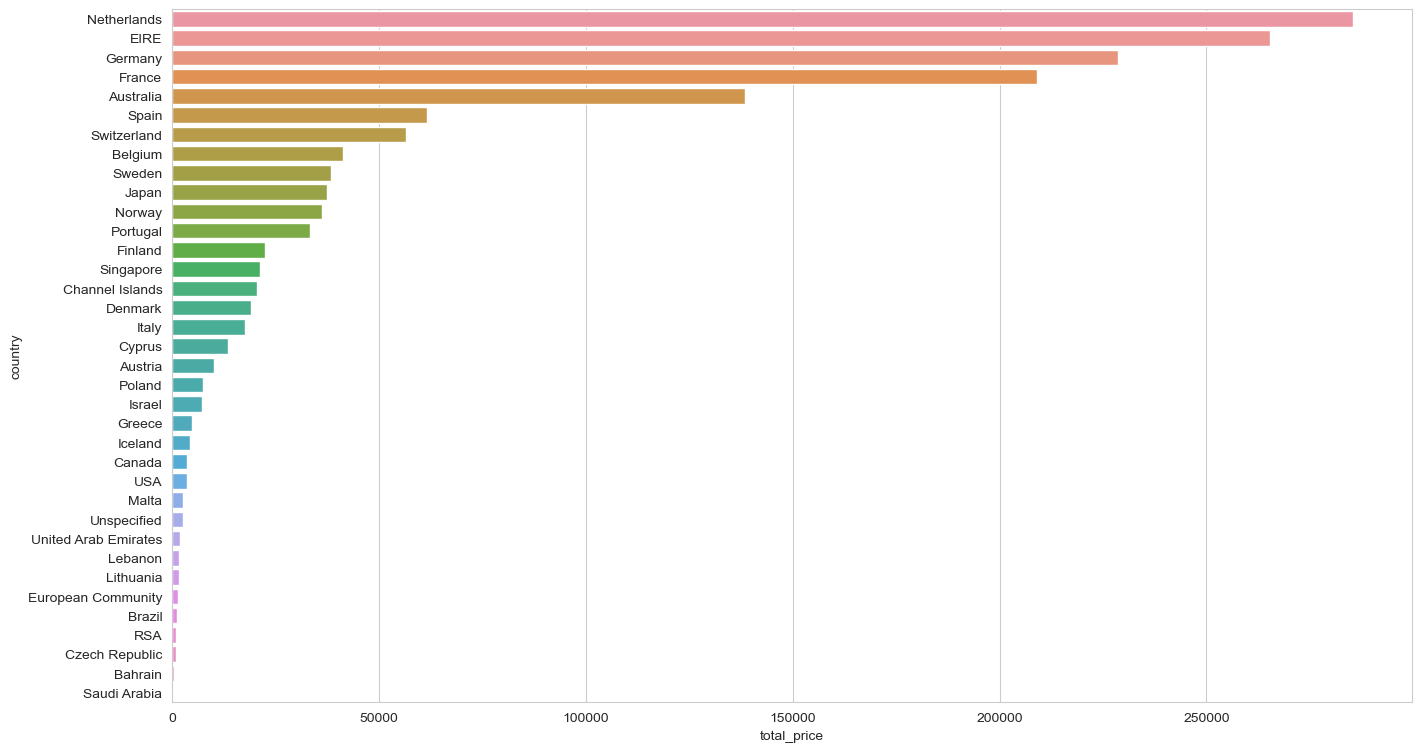

In [49]:
plt.figure(figsize = (16,9))
sns.barplot(data = df_total_price.iloc[1:], x = df_total_price.iloc[1:]["total_price"], y = df_total_price.iloc[1:].index);

**Result:**
The UK is not only the country with the most sales revenue, but also the country with the most customers.
The majority of this dataset includes orders from the UK.
So we can further explore the UK market by learning which products customers buy together and other buying behaviors to improve our sales and targeting strategy.

## Explore the UK Market

In [50]:
df_uk = df[df["country"] == 'United Kingdom']

In [51]:
df_uk.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,total_price
0,536365.0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.000,2010-12-01 08:26:00,2.550,17850.000,United Kingdom,15.300
1,536365.0,71053.0,WHITE METAL LANTERN,6.000,2010-12-01 08:26:00,3.390,17850.000,United Kingdom,20.340
2,536365.0,84406B,CREAM CUPID HEARTS COAT HANGER,8.000,2010-12-01 08:26:00,2.750,17850.000,United Kingdom,22.000
3,536365.0,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.000,2010-12-01 08:26:00,3.390,17850.000,United Kingdom,20.340
4,536365.0,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.000,2010-12-01 08:26:00,3.390,17850.000,United Kingdom,20.340


In [52]:
df_uk.shape

(349203, 9)

**The number of each product sold in the UK**

In [53]:
df_uk["stock_code"].value_counts()

85123A     1936
85099B     1461
22423.0    1417
84879.0    1320
47566.0    1300
           ... 
79323B        1
44265.0       1
47503J        1
84854.0       1
23843.0       1
Name: stock_code, Length: 3645, dtype: int64

**Visualize top 15 most sold products**

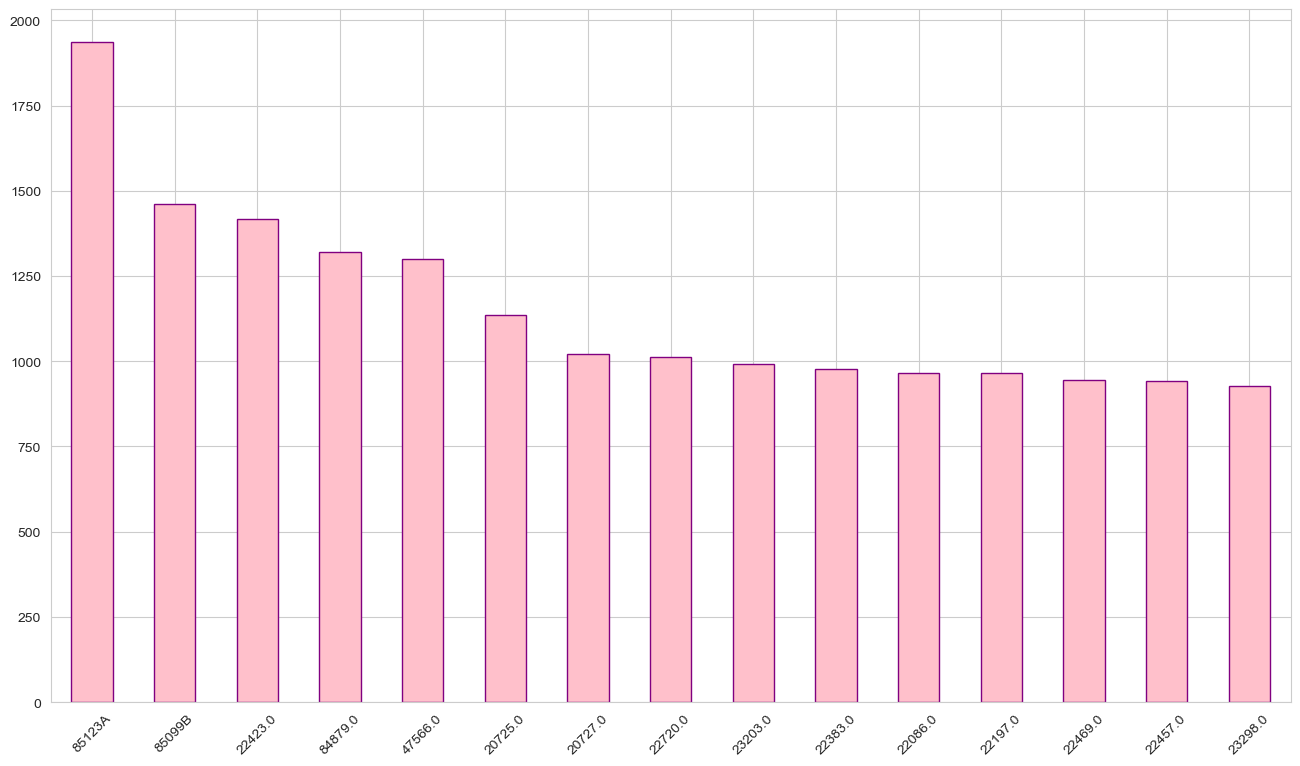

In [54]:
df_uk["stock_code"].value_counts().head(15).plot(kind="bar", width=0.5, color='pink', edgecolor='purple', figsize=(16,9))
plt.xticks(rotation=45);

# <p style="background-color:#1874CD; font-family:newtimeroman; color:#FFF9ED; font-size:130%; text-align:center; border-radius:10px 10px;">RFM Analysis </p>

<a id="3"></a>
<a href="#74" class="btn btn-primary btn-sm" role="button" aria-pressed="true" 
style="color:blue; background-color:#dfa8e4" data-toggle="popover">Table of Contents</a>

In [55]:
df_uk.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,total_price
0,536365.0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.000,2010-12-01 08:26:00,2.550,17850.000,United Kingdom,15.300
1,536365.0,71053.0,WHITE METAL LANTERN,6.000,2010-12-01 08:26:00,3.390,17850.000,United Kingdom,20.340
2,536365.0,84406B,CREAM CUPID HEARTS COAT HANGER,8.000,2010-12-01 08:26:00,2.750,17850.000,United Kingdom,22.000
3,536365.0,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.000,2010-12-01 08:26:00,3.390,17850.000,United Kingdom,20.340
4,536365.0,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.000,2010-12-01 08:26:00,3.390,17850.000,United Kingdom,20.340


## Calculating Recency

In [56]:
last_invoice = max(df_uk['invoice_date'])
last_invoice

'2011-12-09 12:49:00'

In [57]:
first_invoice = min(df_uk['invoice_date'])
first_invoice

'2010-12-01 08:26:00'

In [58]:
df_uk["invoice_date"].dtype.type

numpy.object_

In [59]:
df_uk["invoice_date"]=pd.to_datetime(df_uk["invoice_date"])

In [60]:
df_uk["invoice_date"].dtype.type

numpy.datetime64

In [61]:
df_uk["date"]=df_uk["invoice_date"].dt.date

In [62]:
df_uk.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,total_price,date
0,536365.0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.000,2010-12-01 08:26:00,2.550,17850.000,United Kingdom,15.300,2010-12-01
1,536365.0,71053.0,WHITE METAL LANTERN,6.000,2010-12-01 08:26:00,3.390,17850.000,United Kingdom,20.340,2010-12-01
2,536365.0,84406B,CREAM CUPID HEARTS COAT HANGER,8.000,2010-12-01 08:26:00,2.750,17850.000,United Kingdom,22.000,2010-12-01
3,536365.0,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.000,2010-12-01 08:26:00,3.390,17850.000,United Kingdom,20.340,2010-12-01
4,536365.0,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.000,2010-12-01 08:26:00,3.390,17850.000,United Kingdom,20.340,2010-12-01


**The last date of purchase by CustomerID**

In [63]:
df_uk.groupby("customer_id")["date"].max()

customer_id
12346.000    2011-01-18
12747.000    2011-12-07
12748.000    2011-12-09
12749.000    2011-12-06
12820.000    2011-12-06
                ...    
18280.000    2011-03-07
18281.000    2011-06-12
18282.000    2011-12-02
18283.000    2011-12-06
18287.000    2011-10-28
Name: date, Length: 3920, dtype: object

In [64]:
df_uk.groupby("customer_id")["date"].transform(max)

0         2010-12-02
1         2010-12-02
2         2010-12-02
3         2010-12-02
4         2010-12-02
             ...    
541889    2011-12-09
541890    2011-12-09
541891    2011-12-09
541892    2011-12-09
541893    2011-12-09
Name: date, Length: 349203, dtype: object

In [65]:
df_uk["last_purchased_date"] = df_uk.groupby("customer_id").date.transform(max)
df_uk.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,total_price,date,last_purchased_date
0,536365.0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.000,2010-12-01 08:26:00,2.550,17850.000,United Kingdom,15.300,2010-12-01,2010-12-02
1,536365.0,71053.0,WHITE METAL LANTERN,6.000,2010-12-01 08:26:00,3.390,17850.000,United Kingdom,20.340,2010-12-01,2010-12-02
2,536365.0,84406B,CREAM CUPID HEARTS COAT HANGER,8.000,2010-12-01 08:26:00,2.750,17850.000,United Kingdom,22.000,2010-12-01,2010-12-02
3,536365.0,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.000,2010-12-01 08:26:00,3.390,17850.000,United Kingdom,20.340,2010-12-01,2010-12-02
4,536365.0,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.000,2010-12-01 08:26:00,3.390,17850.000,United Kingdom,20.340,2010-12-01,2010-12-02


**Calculating the days since last purchase**

In [66]:
last_invoice

'2011-12-09 12:49:00'

In [67]:
last_invoice = pd.to_datetime(last_invoice).date()
last_invoice

datetime.date(2011, 12, 9)

In [68]:
 df_uk.groupby('customer_id')['last_purchased_date'].apply(lambda x: last_invoice - x)

0        372 days
1        372 days
2        372 days
3        372 days
4        372 days
           ...   
541889     0 days
541890     0 days
541891     0 days
541892     0 days
541893     0 days
Name: last_purchased_date, Length: 349203, dtype: timedelta64[ns]

In [69]:
df_uk["recency"] = df_uk.groupby('customer_id')['last_purchased_date'].apply(lambda x: last_invoice - x)
df_uk.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,total_price,date,last_purchased_date,recency
0,536365.0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.000,2010-12-01 08:26:00,2.550,17850.000,United Kingdom,15.300,2010-12-01,2010-12-02,372 days
1,536365.0,71053.0,WHITE METAL LANTERN,6.000,2010-12-01 08:26:00,3.390,17850.000,United Kingdom,20.340,2010-12-01,2010-12-02,372 days
2,536365.0,84406B,CREAM CUPID HEARTS COAT HANGER,8.000,2010-12-01 08:26:00,2.750,17850.000,United Kingdom,22.000,2010-12-01,2010-12-02,372 days
3,536365.0,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.000,2010-12-01 08:26:00,3.390,17850.000,United Kingdom,20.340,2010-12-01,2010-12-02,372 days
4,536365.0,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.000,2010-12-01 08:26:00,3.390,17850.000,United Kingdom,20.340,2010-12-01,2010-12-02,372 days


In [70]:
df_uk["recency"]=df_uk.recency.astype("str").str.split(" ").str[0].astype("int")

In [71]:
df_uk.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,total_price,date,last_purchased_date,recency
0,536365.0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.000,2010-12-01 08:26:00,2.550,17850.000,United Kingdom,15.300,2010-12-01,2010-12-02,372
1,536365.0,71053.0,WHITE METAL LANTERN,6.000,2010-12-01 08:26:00,3.390,17850.000,United Kingdom,20.340,2010-12-01,2010-12-02,372
2,536365.0,84406B,CREAM CUPID HEARTS COAT HANGER,8.000,2010-12-01 08:26:00,2.750,17850.000,United Kingdom,22.000,2010-12-01,2010-12-02,372
3,536365.0,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.000,2010-12-01 08:26:00,3.390,17850.000,United Kingdom,20.340,2010-12-01,2010-12-02,372
4,536365.0,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.000,2010-12-01 08:26:00,3.390,17850.000,United Kingdom,20.340,2010-12-01,2010-12-02,372


We will drop 'last_purchased_date' column since we don't need it anymore

In [72]:
df_uk = df_uk.drop('last_purchased_date',axis=1)

In [73]:
df_uk.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,total_price,date,recency
0,536365.0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.000,2010-12-01 08:26:00,2.550,17850.000,United Kingdom,15.300,2010-12-01,372
1,536365.0,71053.0,WHITE METAL LANTERN,6.000,2010-12-01 08:26:00,3.390,17850.000,United Kingdom,20.340,2010-12-01,372
2,536365.0,84406B,CREAM CUPID HEARTS COAT HANGER,8.000,2010-12-01 08:26:00,2.750,17850.000,United Kingdom,22.000,2010-12-01,372
3,536365.0,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.000,2010-12-01 08:26:00,3.390,17850.000,United Kingdom,20.340,2010-12-01,372
4,536365.0,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.000,2010-12-01 08:26:00,3.390,17850.000,United Kingdom,20.340,2010-12-01,372


## Calculating Frequency

In [74]:
df_uk.groupby('customer_id')["invoice_no"].count().sort_values(ascending = False)

customer_id
17841.000    7676
14096.000    5111
12748.000    4412
14606.000    2677
15311.000    2366
             ... 
17347.000       1
15316.000       1
15313.000       1
13270.000       1
12346.000       1
Name: invoice_no, Length: 3920, dtype: int64

In [75]:
df_uk.groupby('customer_id')["invoice_no"].transform('count').sort_values(ascending = False)

388170    7676
303314    7676
303321    7676
303320    7676
303319    7676
          ... 
63201        1
206692       1
293674       1
252          1
255504       1
Name: invoice_no, Length: 349203, dtype: int64

In [76]:
df_uk['frequency'] = df_uk.groupby('customer_id')["invoice_no"].transform('count')

In [77]:
df_uk.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,total_price,date,recency,frequency
0,536365.0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.000,2010-12-01 08:26:00,2.550,17850.000,United Kingdom,15.300,2010-12-01,372,297
1,536365.0,71053.0,WHITE METAL LANTERN,6.000,2010-12-01 08:26:00,3.390,17850.000,United Kingdom,20.340,2010-12-01,372,297
2,536365.0,84406B,CREAM CUPID HEARTS COAT HANGER,8.000,2010-12-01 08:26:00,2.750,17850.000,United Kingdom,22.000,2010-12-01,372,297
3,536365.0,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.000,2010-12-01 08:26:00,3.390,17850.000,United Kingdom,20.340,2010-12-01,372,297
4,536365.0,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.000,2010-12-01 08:26:00,3.390,17850.000,United Kingdom,20.340,2010-12-01,372,297


## Calculating Monetary Values

**Monetary value of is the total amount of money spent. It is calculated by adding together the cost of the customers' purchases.**

In [78]:
df_uk.groupby('customer_id')["total_price"].sum()

customer_id
12346.000   77183.600
12747.000    4196.010
12748.000   33053.190
12749.000    4090.880
12820.000     942.340
               ...   
18280.000     180.600
18281.000      80.820
18282.000     178.050
18283.000    2045.530
18287.000    1837.280
Name: total_price, Length: 3920, dtype: float64

In [79]:
 df_uk.groupby('customer_id')["total_price"].transform('sum')

0         5391.210
1         5391.210
2         5391.210
3         5391.210
4         5391.210
            ...   
541889    4206.390
541890   12245.960
541891   12245.960
541892   12245.960
541893   12245.960
Name: total_price, Length: 349203, dtype: float64

In [80]:
df_uk["monetary"] = df_uk.groupby('customer_id')["total_price"].transform('sum')

In [81]:
df_uk.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,total_price,date,recency,frequency,monetary
0,536365.0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.000,2010-12-01 08:26:00,2.550,17850.000,United Kingdom,15.300,2010-12-01,372,297,5391.210
1,536365.0,71053.0,WHITE METAL LANTERN,6.000,2010-12-01 08:26:00,3.390,17850.000,United Kingdom,20.340,2010-12-01,372,297,5391.210
2,536365.0,84406B,CREAM CUPID HEARTS COAT HANGER,8.000,2010-12-01 08:26:00,2.750,17850.000,United Kingdom,22.000,2010-12-01,372,297,5391.210
3,536365.0,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.000,2010-12-01 08:26:00,3.390,17850.000,United Kingdom,20.340,2010-12-01,372,297,5391.210
4,536365.0,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.000,2010-12-01 08:26:00,3.390,17850.000,United Kingdom,20.340,2010-12-01,372,297,5391.210


## Creating RFM Table

In [82]:
df_rfm_table = df_uk[['customer_id', 'recency', 'frequency', 'monetary']]

In [83]:
df_rfm_table.head()

,customer_id,recency,frequency,monetary
0,17850.000,372,297,5391.210
1,17850.000,372,297,5391.210
2,17850.000,372,297,5391.210
3,17850.000,372,297,5391.210
4,17850.000,372,297,5391.210


# <p style="background-color:#1874CD; font-family:newtimeroman; color:#FFF9ED; font-size:130%; text-align:center; border-radius:10px 10px;"> Customer Segmentation with RFM Scores</p>
<a id="5"></a>
<a href="#74" class="btn btn-primary btn-sm" role="button" aria-pressed="true" 
style="color:blue; background-color:#dfa8e4" data-toggle="popover">Table of Contents</a>

## Calculating RFM Scoring

In [84]:
df_rfm_table = df_rfm_table.set_index('customer_id')
df_rfm_table.head()

,recency,frequency,monetary
customer_id,,,
17850.000,372,297,5391.210
17850.000,372,297,5391.210
17850.000,372,297,5391.210
17850.000,372,297,5391.210
17850.000,372,297,5391.210


In [85]:
df_rfm_table.shape

(349203, 3)

In [86]:
df_rfm_table.duplicated().any()

True

In [87]:
df_rfm_table.reset_index().duplicated().sum()

345283

In [88]:
df_rfm_table.drop_duplicates(inplace=True)
df_rfm_table.shape

(3920, 3)

##  Creating RFM Segmentation Table

**Recency**

In [89]:
df_rfm_table["recency"].quantile(q = [.25,.5,.75])

0.250    17.000
0.500    50.000
0.750   142.000
Name: recency, dtype: float64

In [90]:
def recency_scoring(data):
    if data["recency"] <= 17.000:
        return 4
    elif data["recency"] <= 50.000:
        return 3
    elif data["recency"] <= 142.000:
        return 2
    else:
        return 1

In [91]:
df_rfm_table['recency_quantile'] = df_rfm_table.apply(recency_scoring, axis =1)
df_rfm_table.head()

,recency,frequency,monetary,recency_quantile
customer_id,,,,
17850.000,372,297,5391.210,1
13047.000,31,172,3237.540,3
13748.000,95,28,948.250,2
15100.000,333,3,876.000,1
15291.000,25,103,4668.300,3


**Frequency**

In [92]:
df_rfm_table["frequency"].quantile(q = [.25,.5,.75])

0.250   17.000
0.500   40.000
0.750   98.000
Name: frequency, dtype: float64

In [93]:
def frequency_scoring(data):
    if data.frequency <= 17.000:
        return 1
    elif data.frequency <= 40.000:
        return 2
    elif data.frequency <= 98.000:
        return 3
    else:
        return 4

In [94]:
df_rfm_table['frequency_quantile'] = df_rfm_table.apply(frequency_scoring, axis =1)
df_rfm_table.head()

,recency,frequency,monetary,recency_quantile,frequency_quantile
customer_id,,,,,
17850.000,372,297,5391.210,1,4
13047.000,31,172,3237.540,3,4
13748.000,95,28,948.250,2,2
15100.000,333,3,876.000,1,1
15291.000,25,103,4668.300,3,4


**Monetary**

In [95]:
df_rfm_table["monetary"].quantile(q = [.25,.5,.75])

0.250    298.185
0.500    644.975
0.750   1571.285
Name: monetary, dtype: float64

In [96]:
def monetary_scoring(data):
    if data.monetary <= 298.185:
        return 1
    elif data.monetary <= 644.975:
        return 2
    elif data.monetary <= 1571.285:
        return 3
    else:
        return 4

In [97]:
df_rfm_table['monetary_quantile'] = df_rfm_table.apply(monetary_scoring, axis =1)
df_rfm_table.head()

,recency,frequency,monetary,recency_quantile,frequency_quantile,monetary_quantile
customer_id,,,,,,
17850.000,372,297,5391.210,1,4,4
13047.000,31,172,3237.540,3,4,4
13748.000,95,28,948.250,2,2,3
15100.000,333,3,876.000,1,1,3
15291.000,25,103,4668.300,3,4,4


**Scoring each customer by combining the scores for segmentation.**

In [98]:
def rfm_scoring(data):
    return str(int(data['recency_quantile'])) + str(int(data['frequency_quantile'])) + str(int(data['monetary_quantile']))

In [99]:
df_rfm_table['rfm_score'] = df_rfm_table.apply(rfm_scoring, axis=1)
df_rfm_table.head()

,recency,frequency,monetary,recency_quantile,frequency_quantile,monetary_quantile,rfm_score
customer_id,,,,,,,
17850.000,372,297,5391.210,1,4,4,144
13047.000,31,172,3237.540,3,4,4,344
13748.000,95,28,948.250,2,2,3,223
15100.000,333,3,876.000,1,1,3,113
15291.000,25,103,4668.300,3,4,4,344


In [100]:
df_rfm_table["rfm_score"].dtype.type

numpy.object_

**Defining rfm_level function that tags customers by using RFM_Scrores and Creating a new variable RFM_Level**

In [101]:
df_rfm_table['rfm_level'] = df_rfm_table['recency_quantile'] + df_rfm_table['frequency_quantile'] + df_rfm_table['monetary_quantile']
df_rfm_table.head()

,recency,frequency,monetary,recency_quantile,frequency_quantile,monetary_quantile,rfm_score,rfm_level
customer_id,,,,,,,,
17850.000,372,297,5391.210,1,4,4,144,9
13047.000,31,172,3237.540,3,4,4,344,11
13748.000,95,28,948.250,2,2,3,223,7
15100.000,333,3,876.000,1,1,3,113,5
15291.000,25,103,4668.300,3,4,4,344,11


**Calculating average values for each RFM_Level, and return a size of each segment**

In [102]:
df_rfm_table['rfm_score'].value_counts().sort_values(ascending=False).head()

444    407
111    343
344    184
122    178
211    166
Name: rfm_score, dtype: int64

**The first way to create a "segments" column**

In [103]:
def segments1(data):
    if data['rfm_level'] >= 10 :
        return 'Gold'
    elif (data['rfm_level'] >= 6) and (data['rfm_level'] < 10 ):
        return 'Silver'
    else:  
        return 'Bronze'

In [104]:
df_rfm_table ['segments1'] = df_rfm_table.apply(segments1,axis=1)
df_rfm_table.head()

,recency,frequency,monetary,recency_quantile,frequency_quantile,monetary_quantile,rfm_score,rfm_level,segments1
customer_id,,,,,,,,,
17850.000,372,297,5391.210,1,4,4,144,9,Silver
13047.000,31,172,3237.540,3,4,4,344,11,Gold
13748.000,95,28,948.250,2,2,3,223,7,Silver
15100.000,333,3,876.000,1,1,3,113,5,Bronze
15291.000,25,103,4668.300,3,4,4,344,11,Gold


In [105]:
df_rfm_table["segments1"].value_counts()

Silver    1603
Bronze    1175
Gold      1142
Name: segments1, dtype: int64

**The second way to create a "segments" column**

In [106]:
segments2 = {
             'Customer Segment':
                                ['Champions',
                                 'Loyal Customers',
                                 'Potential Loyalist', 
                                 'Recent Customers', 
                                 'Customers Needing Attention', 
                                 'Still Got Hope', 
                                 'Need to Get Them Back',
                                 'Lost', 'Give it a Try'],\
                           'RFM':
                                ['(3|4)-(3|4)-(3|4)', 
                                 '(2|3|4)-(3|4)-(1|2|3|4)', 
                                 '(3|4)-(2|3)-(1|2|3|4)', 
                                 '(4)-(1)-(1|2|3|4)', 
                                 '(2|3)-(2|3)-(2|3)', 
                                 '(2|3)-(1|2)-(1|2|3|4)', 
                                 '(1|2)-(3|4)-(2|3|4)', 
                                 '(1|2)-(1|2)-(1|2)',
                                 '(1|2)-(1|2|3)-(1|2|3|4)']
            }
pd.DataFrame(segments2)

,Customer Segment,RFM
0,Champions,(3|4)-(3|4)-(3|4)
1,Loyal Customers,(2|3|4)-(3|4)-(1|2|3|4)
2,Potential Loyalist,(3|4)-(2|3)-(1|2|3|4)
3,Recent Customers,(4)-(1)-(1|2|3|4)
4,Customers Needing Attention,(2|3)-(2|3)-(2|3)
5,Still Got Hope,(2|3)-(1|2)-(1|2|3|4)
6,Need to Get Them Back,(1|2)-(3|4)-(2|3|4)
7,Lost,(1|2)-(1|2)-(1|2)
8,Give it a Try,(1|2)-(1|2|3)-(1|2|3|4)


In [107]:
def categorizer(rfm):
    if (rfm[0] in ['3', '4']) & (rfm[1] in ['3', '4']) & (rfm[2] in ['3', '4']):
        rfm = 'Champions'
        
    elif (rfm[0] in ['2', '3', '4']) & (rfm[1] in ['3', '4']) & (rfm[2] in ['1', '2', '3', '4']):
        rfm = 'Loyal Customers'
        
    elif (rfm[0] in ['3', '4']) & (rfm[1] in ['2', '3']) & (rfm[2] in ['1', '2', '3', '4']):
        rfm = 'Potential Loyalist'
    
    elif (rfm[0] in ['4']) & (rfm[1] in ['1']) & (rfm[2] in ['1', '2', '3', '4']):
        rfm = 'Recent Customers'
    
    elif (rfm[0] in ['2', '3']) & (rfm[1] in ['2', '3']) & (rfm[2] in ['2', '3']):
        rfm = 'Customers Needing Attention'
    
    elif (rfm[0] in ['2', '3']) & (rfm[1] in ['1', '2']) & (rfm[2] in ['1', '2', '3', '4']):
        rfm = 'Still Got Hope'
    
    elif (rfm[0] in ['1', '2']) & (rfm[1] in ['3', '4']) & (rfm[2] in ['2', '3', '4']):
        rfm = 'Need to Get Them Back'
                
    elif (rfm[0] in ['1', '2']) & (rfm[1] in ['1', '2']) & (rfm[2] in ['1', '2']):
        rfm = 'Lost'
    
    elif (rfm[0] in ['1', '2']) & (rfm[1] in ['1', '2', '3']) & (rfm[2] in ['1', '2', '3', '4']):
        rfm = 'Give it a Try'
    
    return rfm 

In [108]:
df_rfm_table['segments2'] = df_rfm_table["rfm_score"].apply(categorizer)
df_rfm_table.head()

,recency,frequency,monetary,recency_quantile,frequency_quantile,monetary_quantile,rfm_score,rfm_level,segments1,segments2
customer_id,,,,,,,,,,
17850.000,372,297,5391.210,1,4,4,144,9,Silver,Need to Get Them Back
13047.000,31,172,3237.540,3,4,4,344,11,Gold,Champions
13748.000,95,28,948.250,2,2,3,223,7,Silver,Customers Needing Attention
15100.000,333,3,876.000,1,1,3,113,5,Bronze,Give it a Try
15291.000,25,103,4668.300,3,4,4,344,11,Gold,Champions


In [109]:
df_rfm_table["segments2"].value_counts()

Champions                      1179
Lost                            716
Loyal Customers                 583
Still Got Hope                  513
Potential Loyalist              354
Customers Needing Attention     215
Need to Get Them Back           163
Give it a Try                   100
Recent Customers                 97
Name: segments2, dtype: int64

## Visualizing   RFM Segments

**Segments1**

In [110]:
df_plot1 = pd.DataFrame(df_rfm_table["segments1"].value_counts(dropna=False).sort_values(ascending=False)).reset_index().rename(columns={'index':'Segments', 'segments1':'Customers'})
df_plot1

,Segments,Customers
0,Silver,1603
1,Bronze,1175
2,Gold,1142


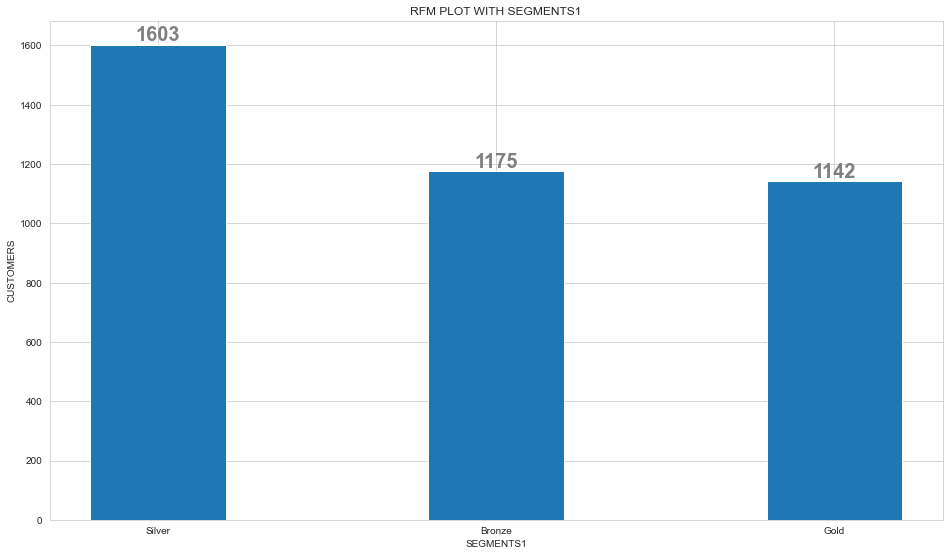

In [111]:
y = df_plot1.Customers.values
x = df_plot1.Segments.values

fig, ax = plt.subplots(figsize = (16,9), dpi=72)
ax.bar(x,y,width=0.4)

plt.title("RFM PLOT WITH SEGMENTS1")
plt.xlabel("SEGMENTS1");
plt.ylabel("CUSTOMERS");

for index,value in enumerate(y):
    plt.text(x=index , y =value , s=str(value) , ha="center", va="bottom", color = 'gray', fontweight = 'bold', fontdict=dict(fontsize=20))
plt.show();

**Segments2**

In [112]:
df_plot2 = pd.DataFrame(df_rfm_table["segments2"].value_counts(dropna=False).sort_values(ascending=False)).reset_index().rename(columns={'index':'Segments', 'segments2':'Customers'})
df_plot2

,Segments,Customers
0,Champions,1179
1,Lost,716
2,Loyal Customers,583
3,Still Got Hope,513
4,Potential Loyalist,354
5,Customers Needing Attention,215
6,Need to Get Them Back,163
7,Give it a Try,100
8,Recent Customers,97


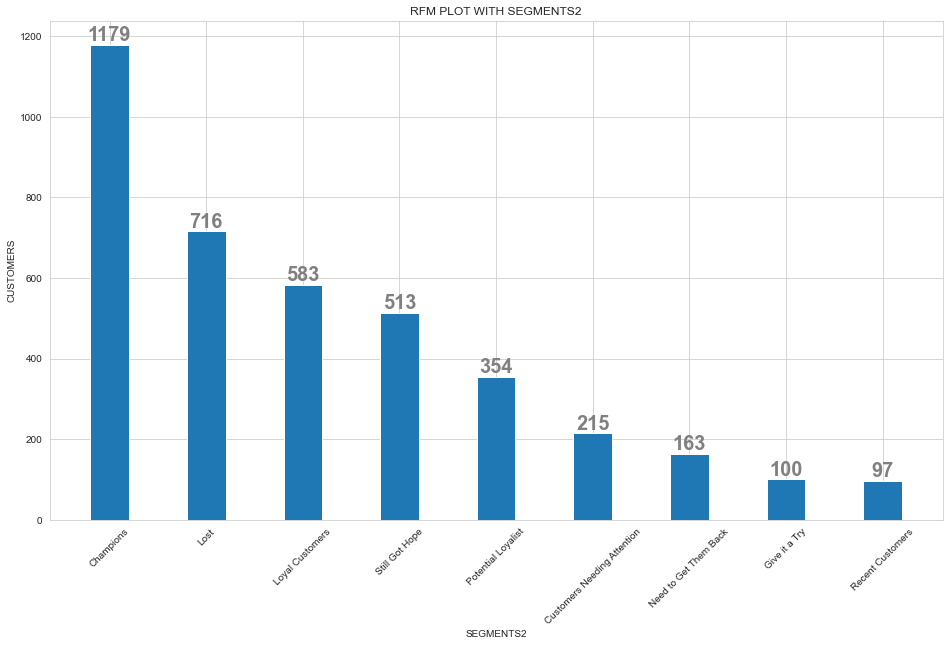

In [113]:
y = df_plot2.Customers.values
x = df_plot2.Segments.values

fig, ax = plt.subplots(figsize = (16,9), dpi=72)
ax.bar(x,y,width=0.4)

plt.title("RFM PLOT WITH SEGMENTS2")
plt.xlabel("SEGMENTS2");
plt.ylabel("CUSTOMERS");
plt.xticks(rotation = 45)

for index,value in enumerate(y):
    plt.text(x=index , y =value , s=str(value) , ha="center", va="bottom", color = 'gray', fontweight = 'bold', fontdict=dict(fontsize=20))
plt.show()

In [114]:
list(df_plot2['Customers'].values)

[1179, 716, 583, 513, 354, 215, 163, 100, 97]

In [115]:
list(df_plot2["Segments"].values)

['Champions',
 'Lost',
 'Loyal Customers',
 'Still Got Hope',
 'Potential Loyalist',
 'Customers Needing Attention',
 'Need to Get Them Back',
 'Give it a Try',
 'Recent Customers']

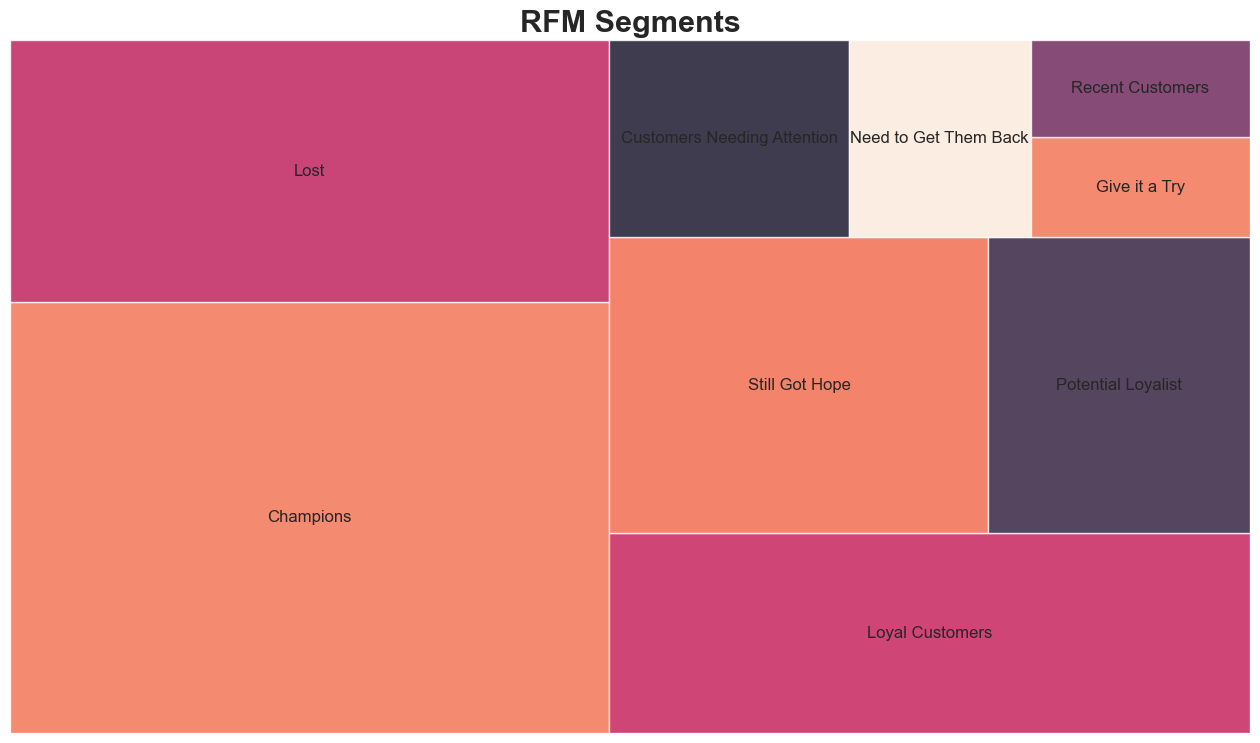

In [116]:
import squarify

fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 9)
squarify.plot(sizes=list(df_plot2['Customers'].values), 
              label=list(df_plot2['Segments'].values), alpha=0.8,
              text_kwargs={'fontsize':12})
plt.title("RFM Segments",fontsize=22,fontweight="bold")
plt.axis('off')
plt.show()


# <p style="background-color:#1874CD; font-family:newtimeroman; color:#FFF9ED; font-size:130%; text-align:center; border-radius:10px 10px;">Applying K-Means Clustering</p>

<a id="6"></a>
<a href="#74" class="btn btn-primary btn-sm" role="button" aria-pressed="true" 
style="color:blue; background-color:#dfa8e4" data-toggle="popover">Table of Contents</a>

## Data Pre-Processing and Exploring

In [117]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from pyclustertend import hopkins
from sklearn.preprocessing import scale
from sklearn.metrics.cluster import adjusted_rand_score
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_samples,silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram

In [118]:
df_rfm_table.head()

,recency,frequency,monetary,recency_quantile,frequency_quantile,monetary_quantile,rfm_score,rfm_level,segments1,segments2
customer_id,,,,,,,,,,
17850.000,372,297,5391.210,1,4,4,144,9,Silver,Need to Get Them Back
13047.000,31,172,3237.540,3,4,4,344,11,Gold,Champions
13748.000,95,28,948.250,2,2,3,223,7,Silver,Customers Needing Attention
15100.000,333,3,876.000,1,1,3,113,5,Bronze,Give it a Try
15291.000,25,103,4668.300,3,4,4,344,11,Gold,Champions


In [119]:
df_rfm_table.groupby('rfm_level').agg(
                                 {'recency': ['mean','min','max','count'],
                                  'frequency': ['mean','min','max','count'],
                                  'monetary': ['mean','min','max','count']}
                                ).round(1)

recency                 frequency                 monetary           \
             mean  min  max count      mean min   max count     mean      min   
rfm_level                                                                       
3         258.100  143  373   343     8.100   1    17   343  151.900    3.800   
4         175.400   51  373   361    13.600   1    39   361  233.500    6.200   
5         151.400   18  373   471    20.500   1    84   471  354.700    6.900   
6          97.200    1  373   426    28.200   1    98   426  825.200   35.400   
7          78.600    1  358   387    38.400   1   123   387  734.100  114.300   
8          60.100    0  338   413    54.500   3   248   413  906.400  120.000   
9          46.900    0  372   377    77.700   1   521   377 1792.500  271.200   
10         32.300    0  140   387   111.100  20   400   387 1914.700  302.100   
11         20.100    0   50   348   182.300  41  1175   348 3434.500  653.200   
12          6.600    0   17   407   360.500  99  7676   407 8254.600 1581.800   

                            
                 max count  
rfm_level                   
3            298.100   343  
4            635.700   361  
5           1308.500   471  
6          77183.600   426  
7           7374.900   387  
8           6912.000   413  
9         168472.500   377  
10         42056.000   387  
11         80850.800   348  
12        259657.300   407

In [120]:
df_rfm_table.corr()

,recency,frequency,monetary,recency_quantile,frequency_quantile,monetary_quantile,rfm_level
recency,1.000,-0.213,-0.129,-0.861,-0.444,-0.444,-0.696
frequency,-0.213,1.000,0.330,0.266,0.409,0.353,0.409
monetary,-0.129,0.330,1.000,0.174,0.197,0.261,0.251
recency_quantile,-0.861,0.266,0.174,1.000,0.469,0.457,0.766
frequency_quantile,-0.444,0.409,0.197,0.469,1.000,0.736,0.877
monetary_quantile,-0.444,0.353,0.261,0.457,0.736,1.000,0.872
rfm_level,-0.696,0.409,0.251,0.766,0.877,0.872,1.000


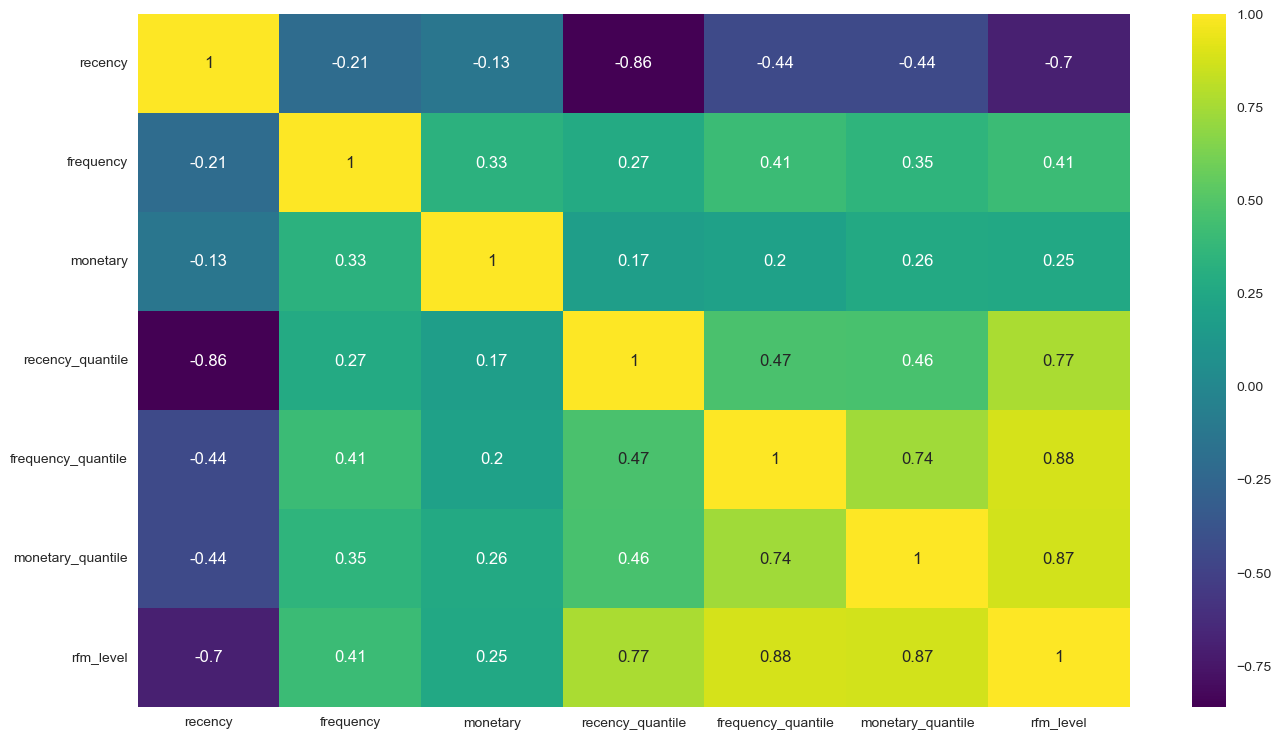

In [121]:
plt.figure(figsize=(16,9))
sns.heatmap(data = df_rfm_table.corr(), annot=True, cmap = 'viridis');

## Data Normalization

In [122]:
compare = {'log1p': df_rfm_table['recency'].apply(np.log1p).values,
           'log'  : (df_rfm_table['recency'] + 0.1).apply(np.log).values}

pd.DataFrame(compare, index = df_rfm_table.index)

,log1p,log
customer_id,,
17850.000,5.922,5.919
13047.000,3.466,3.437
13748.000,4.564,4.555
15100.000,5.811,5.808
15291.000,3.258,3.223
...,...,...
15471.000,1.099,0.742
13436.000,0.693,0.095
15520.000,0.693,0.095


In [123]:
rfm_log = df_rfm_table[['recency', 'frequency', 'monetary']].apply(np.log1p).round(3)
rfm_log

,recency,frequency,monetary
customer_id,,,
17850.000,5.922,5.697,8.593
13047.000,3.466,5.153,8.083
13748.000,4.564,3.367,6.856
15100.000,5.811,1.386,6.777
15291.000,3.258,4.644,8.449
...,...,...,...
15471.000,1.099,4.304,6.121
13436.000,0.693,2.565,5.288
15520.000,0.693,2.944,5.842


<Figure size 2000x1000 with 0 Axes>

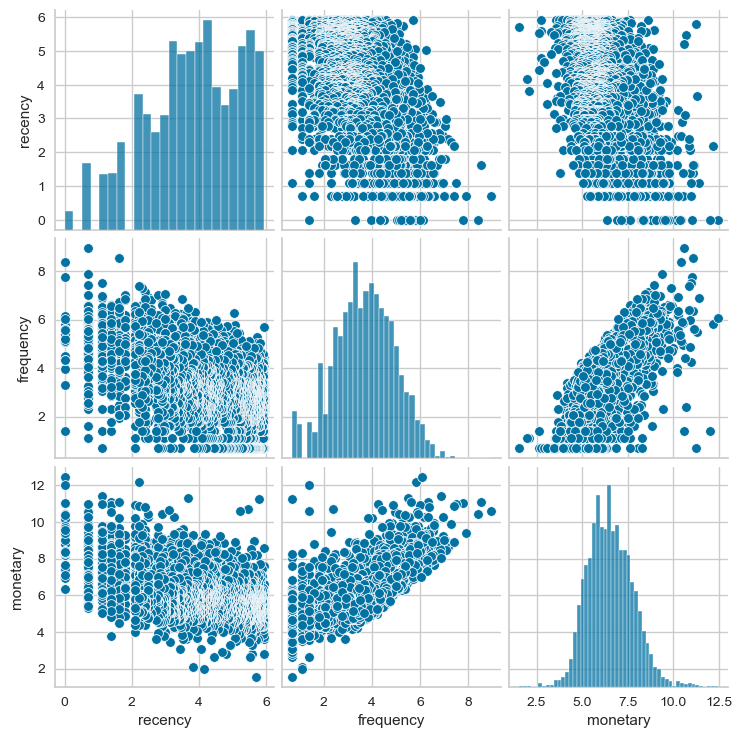

In [124]:
plt.figure(figsize=(20,10))
sns.pairplot(data = rfm_log);

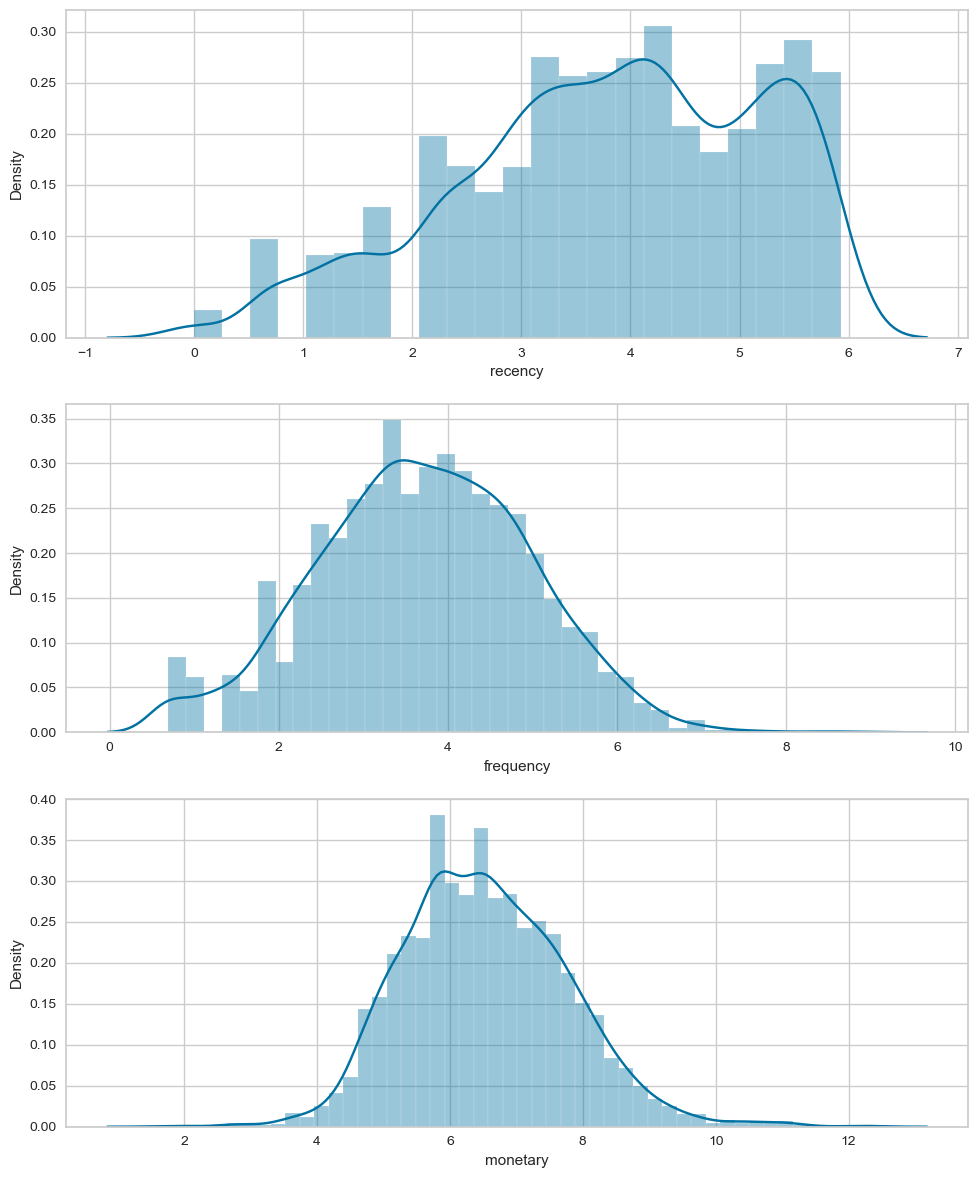

In [125]:
f,ax = plt.subplots(figsize=(10, 12))
plt.subplot(3, 1, 1); sns.distplot(rfm_log.recency, label = 'Recency')
plt.subplot(3, 1, 2); sns.distplot(rfm_log.frequency, label = 'Frequency')
plt.subplot(3, 1, 3); sns.distplot(rfm_log.monetary, label = 'Monetary')
plt.style.use('fivethirtyeight')
plt.tight_layout()
plt.show()

**Normalize the variables with StandardScaler**

In [126]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(rfm_log)
rfm_normalized= scaler.transform(rfm_log)

##  K-Means Implementation

**Optimal Cluster Number (K) by using "Elbow Method"**

In [127]:
hopkins(rfm_log,rfm_log.shape[0])

0.09968471790520723

* The Hopkins value is too close to 0 which means we have a dataset which has a quite small tendency to clustering. We need to further analyze with Silhouette scores whether our data has a tendency to clustering or not.

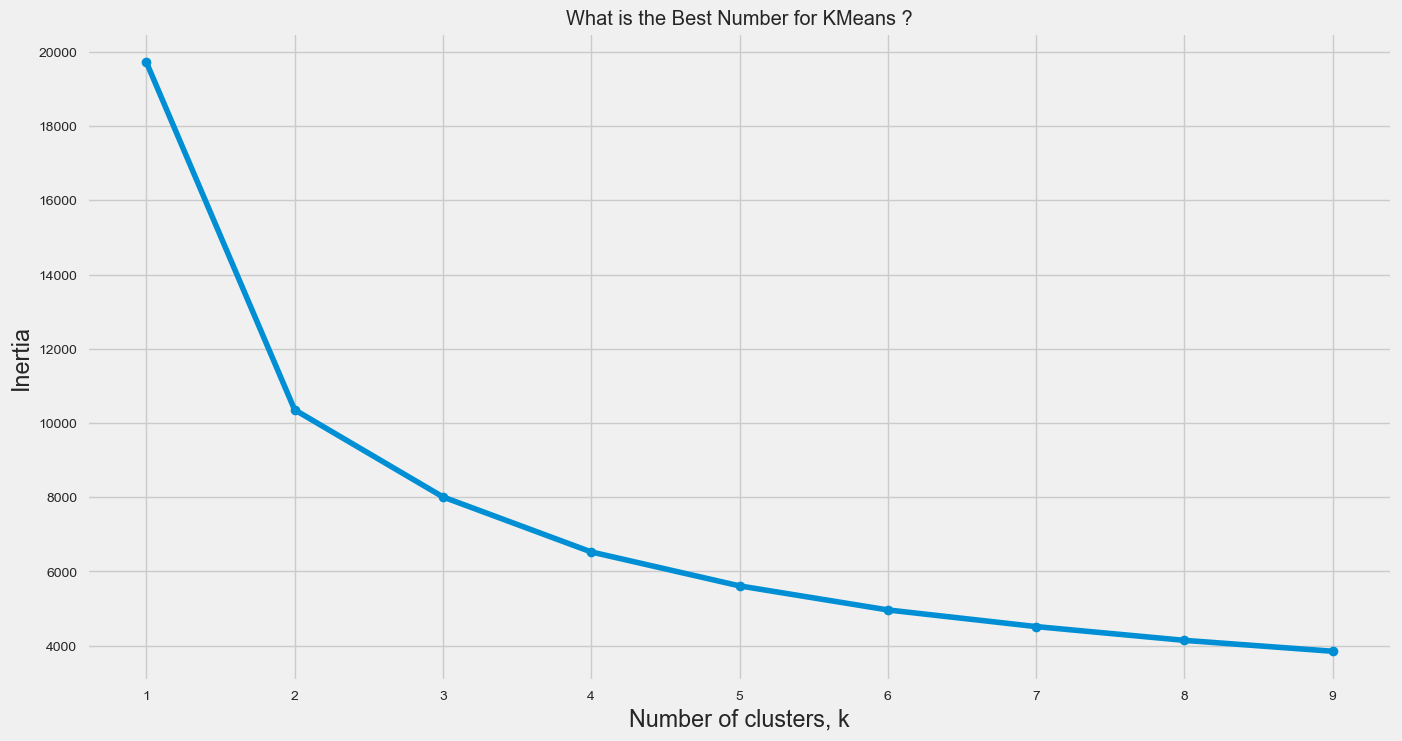

In [128]:
ks = range(1,10)
inertias=[]
for k in ks :
    # Create a KMeans clusters
    kc = KMeans(n_clusters=k,random_state=1)
    kc.fit(rfm_log)
    inertias.append(kc.inertia_)

# Plot ks vs inertias
f, ax = plt.subplots(figsize=(15, 8))
plt.plot(ks, inertias, '-o')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.style.use('ggplot')
plt.title('What is the Best Number for KMeans ?')
plt.show()

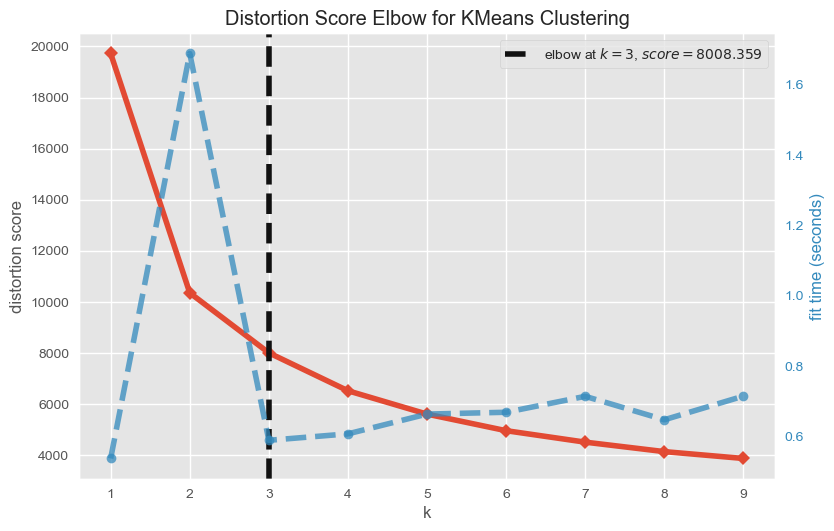

In [129]:
plt.rcParams['figure.facecolor'] = 'white'
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))

visualizer.fit(rfm_log)
visualizer.show();

**Optimal Cluster Number (K) by using "Silhouette score"**

In [130]:
for k in range(2,10):

    model = KMeans(n_clusters=k)  #  random_state=10
    cluster_labels = model.fit_predict(rfm_log)
    
    print("For n_clusters =", k,
          "The average silhouette_score is :", silhouette_score(rfm_log, cluster_labels))

For n_clusters = 2 The average silhouette_score is : 0.3986146833692344
For n_clusters = 3 The average silhouette_score is : 0.30475067954293805
For n_clusters = 4 The average silhouette_score is : 0.31157136029311255
For n_clusters = 5 The average silhouette_score is : 0.2770391122747756
For n_clusters = 6 The average silhouette_score is : 0.2779735847147608
For n_clusters = 7 The average silhouette_score is : 0.2619016747974948
For n_clusters = 8 The average silhouette_score is : 0.26054359393251775
For n_clusters = 9 The average silhouette_score is : 0.2614563379390412


* Silhouette_score decreases as the level of detail increases, that is, as the number of clusters (n_clusters) increases.
* From this, the following conclusions can be drawn: Our first finding regarding the clustering tendency is supported by the score that we obtained with the Hopkins method, which we found to be very close to zero.
* For the clustering, we will choose the n_clusters=3 that have an acceptable elbow score.
(The Yellowbrick Elbow method recommends 3 clusters, but the silhouette score is too low for 3 n_clouster.)

## Model Fitting

In [131]:
kmeans = KMeans(n_clusters = 3, random_state=101)

In [132]:
kmeans.fit(rfm_log)

KMeans(n_clusters=3, random_state=101)

In [133]:
labels=kmeans.labels_

In [134]:
rfm_log['labels']=labels

In [135]:
rfm_log.head()

,recency,frequency,monetary,labels
customer_id,,,,
17850.000,5.922,5.697,8.593,2
13047.000,3.466,5.153,8.083,0
13748.000,4.564,3.367,6.856,2
15100.000,5.811,1.386,6.777,1
15291.000,3.258,4.644,8.449,0


## Visualize the Clusters

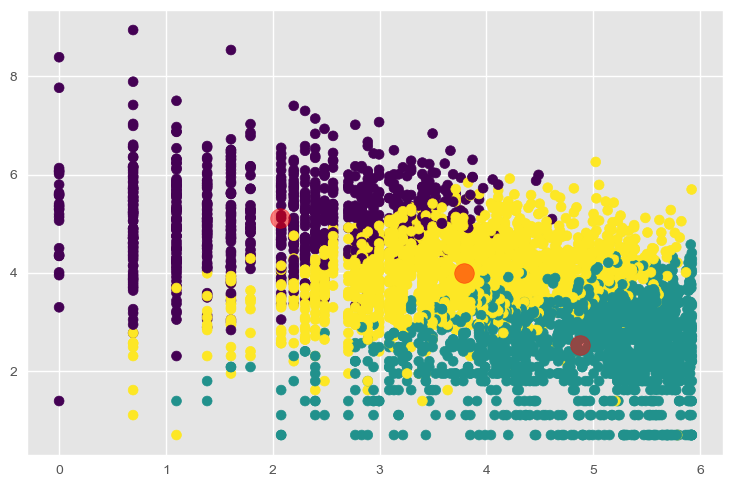

In [136]:
plt.scatter(rfm_log.iloc[:,0], rfm_log.iloc[:,1], c = labels, s = 50, cmap = "viridis")
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='red',alpha=0.5, label = 'Centroids');

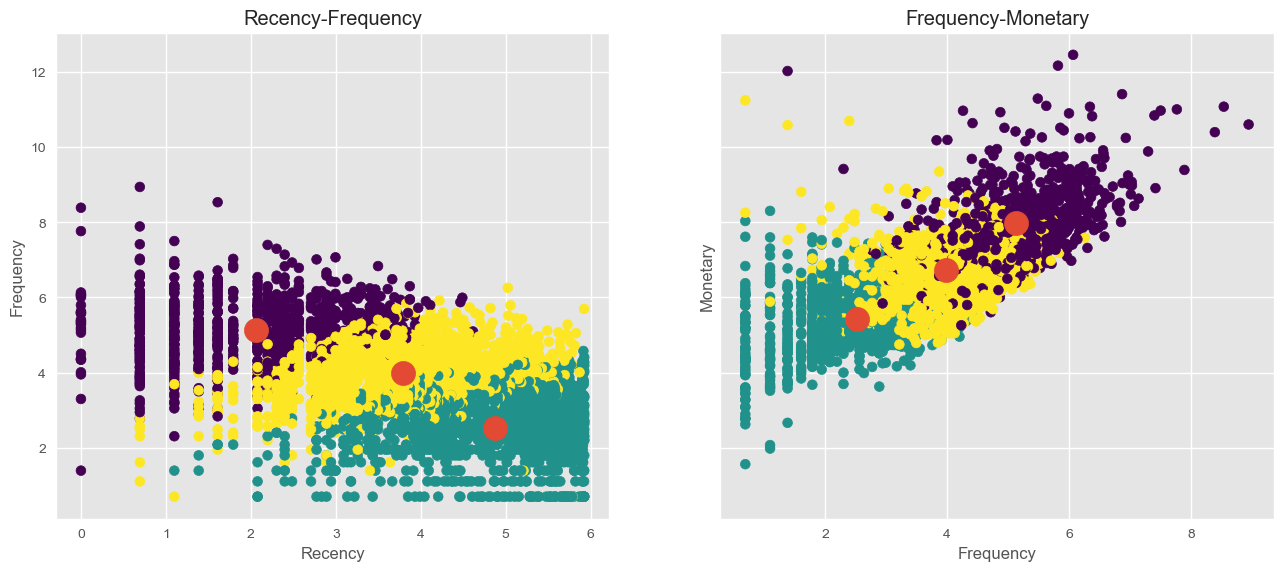

In [137]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize = (14,6)) # sharey=True and y-axis labels are used in common.
ax1.set_title('Recency-Frequency')
ax1.set_xlabel('Recency')
ax1.set_ylabel('Frequency')
ax1.scatter(rfm_log["recency"], rfm_log["frequency"], c = kmeans.labels_, cmap = "viridis")
ax1.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], s = 300, alpha = 1, label = 'Centroids')

ax2.set_title("Frequency-Monetary")
ax2.set_xlabel('Frequency')
ax2.set_ylabel('Monetary')
ax2.scatter(rfm_log["frequency"], rfm_log["monetary"], c = kmeans.labels_, cmap ="viridis")
ax2.scatter(kmeans.cluster_centers_[:,1], kmeans.cluster_centers_[:,2], s = 300, alpha = 1, label = 'Centroids');

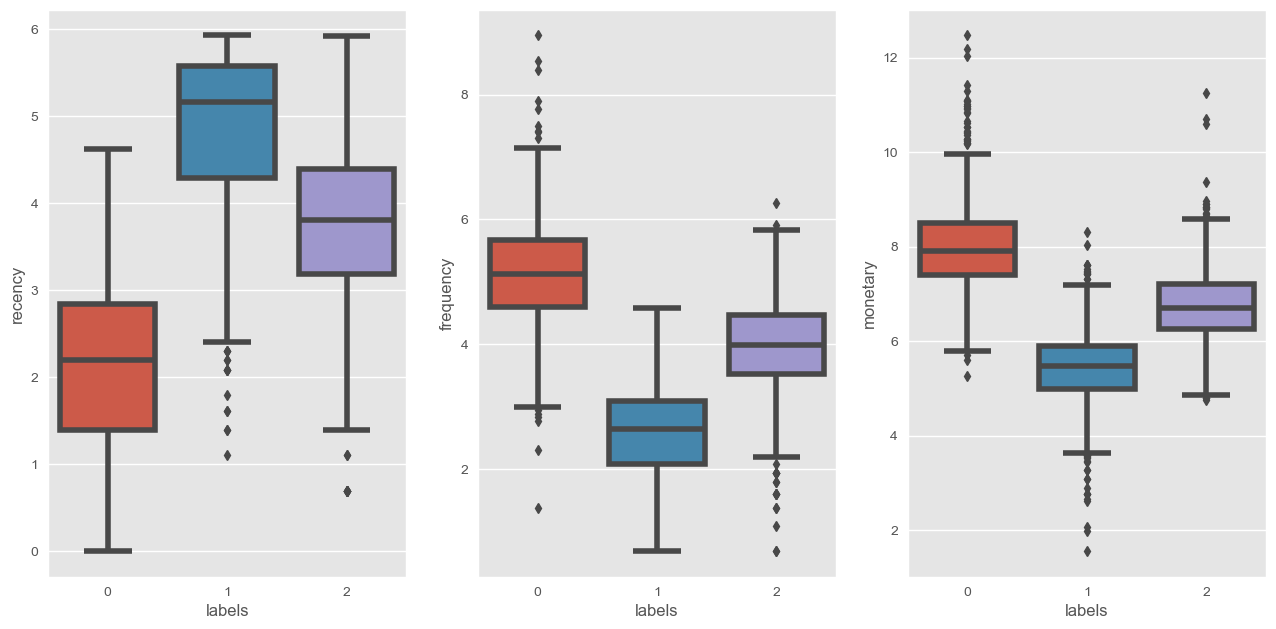

In [138]:
plt.figure(figsize = (14,7))

plt.subplot(1,3,1)
sns.boxplot(rfm_log['labels'], rfm_log['recency'])

plt.subplot(1,3,2)
sns.boxplot(rfm_log['labels'], rfm_log['frequency'])

plt.subplot(1,3,3)
sns.boxplot(rfm_log['labels'], rfm_log['monetary'])
plt.show()

 ## Assign the Labels

In [139]:
rfm_log.head()

,recency,frequency,monetary,labels
customer_id,,,,
17850.000,5.922,5.697,8.593,2
13047.000,3.466,5.153,8.083,0
13748.000,4.564,3.367,6.856,2
15100.000,5.811,1.386,6.777,1
15291.000,3.258,4.644,8.449,0


In [140]:
rfm_log["labels"].value_counts(dropna = False)

2    1638
1    1416
0     866
Name: labels, dtype: int64

In [141]:
rfm_log['decision'] = rfm_log['labels'].apply(lambda item: 'Best_Customers' if item == 1 else ("Almost_Lost" if item == 2 else "Lost_Customers"))
rfm_log.head() 

,recency,frequency,monetary,labels,decision
customer_id,,,,,
17850.000,5.922,5.697,8.593,2,Almost_Lost
13047.000,3.466,5.153,8.083,0,Lost_Customers
13748.000,4.564,3.367,6.856,2,Almost_Lost
15100.000,5.811,1.386,6.777,1,Best_Customers
15291.000,3.258,4.644,8.449,0,Lost_Customers


## Conclusion

* Cluster 1 : The first cluster belongs to the "Best Customers" segment which we saw earlier as they purchase recently (R=4), frequent buyers (F=4), and spent the most (M=4)

* Cluster 0 : Second cluster can be interpreted as passer customers as their last purchase is long ago (R<=1),purchased very few (F>=2 & F < 4) and spent little (M>=4 & M < 4).Company has to come up with new strategies to make them permanent members. Low value customers

* Cluster 2 : The third cluster is more related to the "Almost Lost" segment as they Haven’t purchased for some time(R=1), but used to purchase frequently and spent a lot.

# <p style="background-color:#1874CD; font-family:newtimeroman; color:#FFF9ED; font-size:130%; text-align:center; border-radius:10px 10px;">Create Cohort & Conduct Cohort Analysis</p>

<a id="7"></a>
<a href="#74" class="btn btn-primary btn-sm" role="button" aria-pressed="true" 
style="color:blue; background-color:#dfa8e4" data-toggle="popover">Table of Contents</a>

## Extract the Month of the Purchase

In [142]:
df_cohort = df
df_cohort.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,total_price
0,536365.0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.000,2010-12-01 08:26:00,2.550,17850.000,United Kingdom,15.300
1,536365.0,71053.0,WHITE METAL LANTERN,6.000,2010-12-01 08:26:00,3.390,17850.000,United Kingdom,20.340
2,536365.0,84406B,CREAM CUPID HEARTS COAT HANGER,8.000,2010-12-01 08:26:00,2.750,17850.000,United Kingdom,22.000
3,536365.0,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.000,2010-12-01 08:26:00,3.390,17850.000,United Kingdom,20.340
4,536365.0,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.000,2010-12-01 08:26:00,3.390,17850.000,United Kingdom,20.340


In [143]:
import datetime as dt
def take_months(x) : 
    return dt.datetime(x.year,x.month,1)

In [144]:
 df_cohort['invoice_date']=pd.to_datetime(df_cohort['invoice_date'])

In [145]:
 df_cohort['invoice_date'].apply(take_months)

0        2010-12-01
1        2010-12-01
2        2010-12-01
3        2010-12-01
4        2010-12-01
            ...    
541904   2011-12-01
541905   2011-12-01
541906   2011-12-01
541907   2011-12-01
541908   2011-12-01
Name: invoice_date, Length: 392692, dtype: datetime64[ns]

In [146]:
df_cohort['invoice_month'] = df_cohort['invoice_date'].apply(take_months)
df_cohort[["invoice_month"]].head()

,invoice_month
0,2010-12-01
1,2010-12-01
2,2010-12-01
3,2010-12-01
4,2010-12-01


In [147]:
df_cohort['cohort_month'] = df_cohort.groupby('customer_id')['invoice_month'].transform('min')
df_cohort[['cohort_month']].head(2)

,cohort_month
0,2010-12-01
1,2010-12-01


## Calculating time offset in Months i.e. Cohort Index:

In [148]:
def get_month_int (dframe,column):
    year = dframe[column].dt.year
    month = dframe[column].dt.month
    day = dframe[column].dt.day
    return year, month , day 

In [149]:
invoice_year, invoice_month, invoice_day = get_month_int(df_cohort, 'invoice_month')
cohort_year, cohort_month, cohort_day = get_month_int(df_cohort, 'cohort_month')

In [150]:
year_diff = invoice_year - cohort_year 
month_diff = invoice_month - cohort_month 

df_cohort['cohort_index'] = year_diff * 12 + month_diff + 1 

In [151]:
df_cohort.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,total_price,invoice_month,cohort_month,cohort_index
0,536365.0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.000,2010-12-01 08:26:00,2.550,17850.000,United Kingdom,15.300,2010-12-01,2010-12-01,1
1,536365.0,71053.0,WHITE METAL LANTERN,6.000,2010-12-01 08:26:00,3.390,17850.000,United Kingdom,20.340,2010-12-01,2010-12-01,1
2,536365.0,84406B,CREAM CUPID HEARTS COAT HANGER,8.000,2010-12-01 08:26:00,2.750,17850.000,United Kingdom,22.000,2010-12-01,2010-12-01,1
3,536365.0,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.000,2010-12-01 08:26:00,3.390,17850.000,United Kingdom,20.340,2010-12-01,2010-12-01,1
4,536365.0,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.000,2010-12-01 08:26:00,3.390,17850.000,United Kingdom,20.340,2010-12-01,2010-12-01,1


## Create 1st Cohort: User number & Retention Rate

**Pivot Cohort and Cohort Retention**

In [152]:
cohort1 = df_cohort.groupby(['cohort_month', 'cohort_index'])['customer_id'].nunique().reset_index()
cohort1.head()

,cohort_month,cohort_index,customer_id
0,2010-12-01,1,885
1,2010-12-01,2,324
2,2010-12-01,3,286
3,2010-12-01,4,340
4,2010-12-01,5,321


In [153]:
pivot_cohort1 = cohort1.reset_index().pivot(index='cohort_month',columns='cohort_index',values='customer_id').round(1)
pivot_cohort1

cohort_index,1,2,3,4,5,6,7,8,9,10,11,12,13
cohort_month,,,,,,,,,,,,,
2010-12-01,885.000,324.000,286.000,340.000,321.000,352.000,321.000,309.000,313.000,350.000,331.000,445.000,235.000
2011-01-01,417.000,92.000,111.000,96.000,134.000,120.000,103.000,101.000,125.000,136.000,152.000,49.000,NaN
2011-02-01,380.000,71.000,71.000,108.000,103.000,94.000,96.000,106.000,94.000,116.000,26.000,NaN,NaN
2011-03-01,452.000,68.000,114.000,90.000,101.000,76.000,121.000,104.000,126.000,39.000,NaN,NaN,NaN
2011-04-01,300.000,64.000,61.000,63.000,59.000,68.000,65.000,78.000,22.000,NaN,NaN,NaN,NaN
2011-05-01,284.000,54.000,49.000,49.000,59.000,66.000,75.000,27.000,NaN,NaN,NaN,NaN,NaN
2011-06-01,242.000,42.000,38.000,64.000,56.000,81.000,23.000,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,188.000,34.000,39.000,42.000,51.000,21.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,169.000,35.000,42.000,41.000,21.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [154]:
sizes = pivot_cohort1.iloc[:, 0]
retention = pivot_cohort1.divide(sizes, axis=0).round(3)*100  #axis=0 to ensure the divide along the row axis
retention

cohort_index,1,2,3,4,5,6,7,8,9,10,11,12,13
cohort_month,,,,,,,,,,,,,
2010-12-01,100.000,36.600,32.300,38.400,36.300,39.800,36.300,34.900,35.400,39.500,37.400,50.300,26.600
2011-01-01,100.000,22.100,26.600,23.000,32.100,28.800,24.700,24.200,30.000,32.600,36.500,11.800,NaN
2011-02-01,100.000,18.700,18.700,28.400,27.100,24.700,25.300,27.900,24.700,30.500,6.800,NaN,NaN
2011-03-01,100.000,15.000,25.200,19.900,22.300,16.800,26.800,23.000,27.900,8.600,NaN,NaN,NaN
2011-04-01,100.000,21.300,20.300,21.000,19.700,22.700,21.700,26.000,7.300,NaN,NaN,NaN,NaN
2011-05-01,100.000,19.000,17.300,17.300,20.800,23.200,26.400,9.500,NaN,NaN,NaN,NaN,NaN
2011-06-01,100.000,17.400,15.700,26.400,23.100,33.500,9.500,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,100.000,18.100,20.700,22.300,27.100,11.200,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,100.000,20.700,24.900,24.300,12.400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Visualizing analysis of cohort 1**

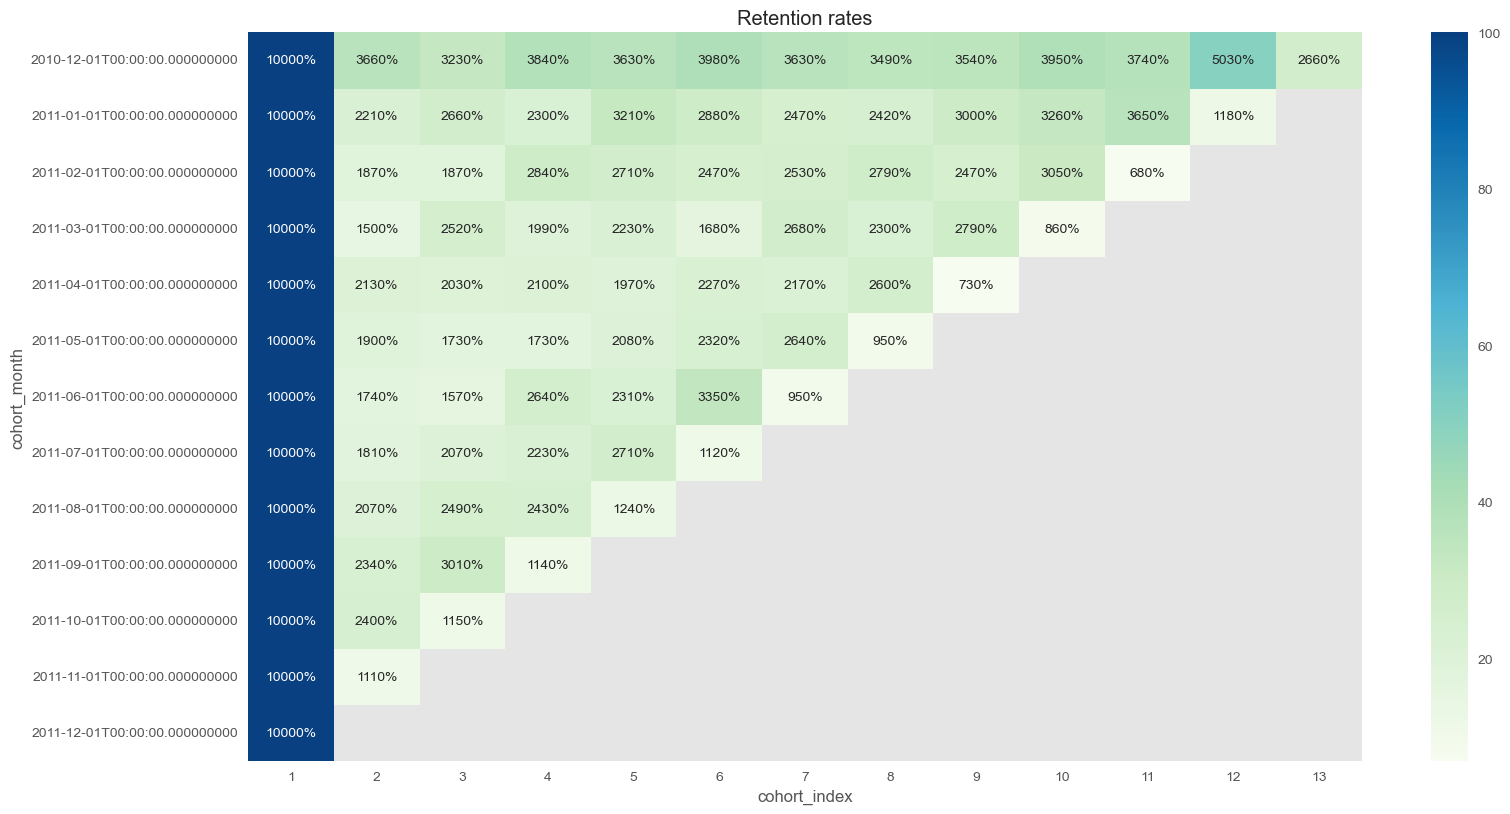

In [155]:
plt.figure(figsize = (16, 9))
plt.title('Retention rates')
sns.heatmap(data=retention, annot=True, fmt='.0%', cmap="GnBu")
plt.show()

## Create the 2nd Cohort: Average Quantity Sold

**Pivot Cohort and Cohort Retention**

In [156]:
cohort2 = df_cohort.groupby(['cohort_month', 'cohort_index'])['quantity'].mean().reset_index()
cohort2.head()

,cohort_month,cohort_index,quantity
0,2010-12-01,1,12.117
1,2010-12-01,2,15.670
2,2010-12-01,3,15.726
3,2010-12-01,4,15.931
4,2010-12-01,5,13.625


In [157]:
pivot_cohort2 = cohort2.pivot(index='cohort_month', columns='cohort_index', values='quantity').round(1)
pivot_cohort2

cohort_index,1,2,3,4,5,6,7,8,9,10,11,12,13
cohort_month,,,,,,,,,,,,,
2010-12-01,12.100,15.700,15.700,15.900,13.600,14.900,16.100,15.600,18.200,17.700,19.000,13.600,15.400
2011-01-01,17.500,13.500,12.700,15.300,12.800,15.400,15.000,15.000,11.600,10.600,9.600,10.200,NaN
2011-02-01,11.200,13.700,19.000,12.000,12.300,12.300,13.600,13.400,11.000,12.400,13.400,NaN,NaN
2011-03-01,10.000,11.700,13.300,10.100,13.800,13.000,13.500,13.900,11.300,9.700,NaN,NaN,NaN
2011-04-01,10.000,10.400,9.800,11.900,12.000,8.700,10.000,9.700,7.600,NaN,NaN,NaN,NaN
2011-05-01,11.500,9.700,14.200,12.800,11.200,8.800,10.800,113.800,NaN,NaN,NaN,NaN,NaN
2011-06-01,10.700,14.700,10.900,13.700,10.700,10.000,9.500,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,9.900,13.800,7.400,8.200,6.200,7.200,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,10.100,6.200,5.400,6.200,7.100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Visualizing analysis of cohort 2**

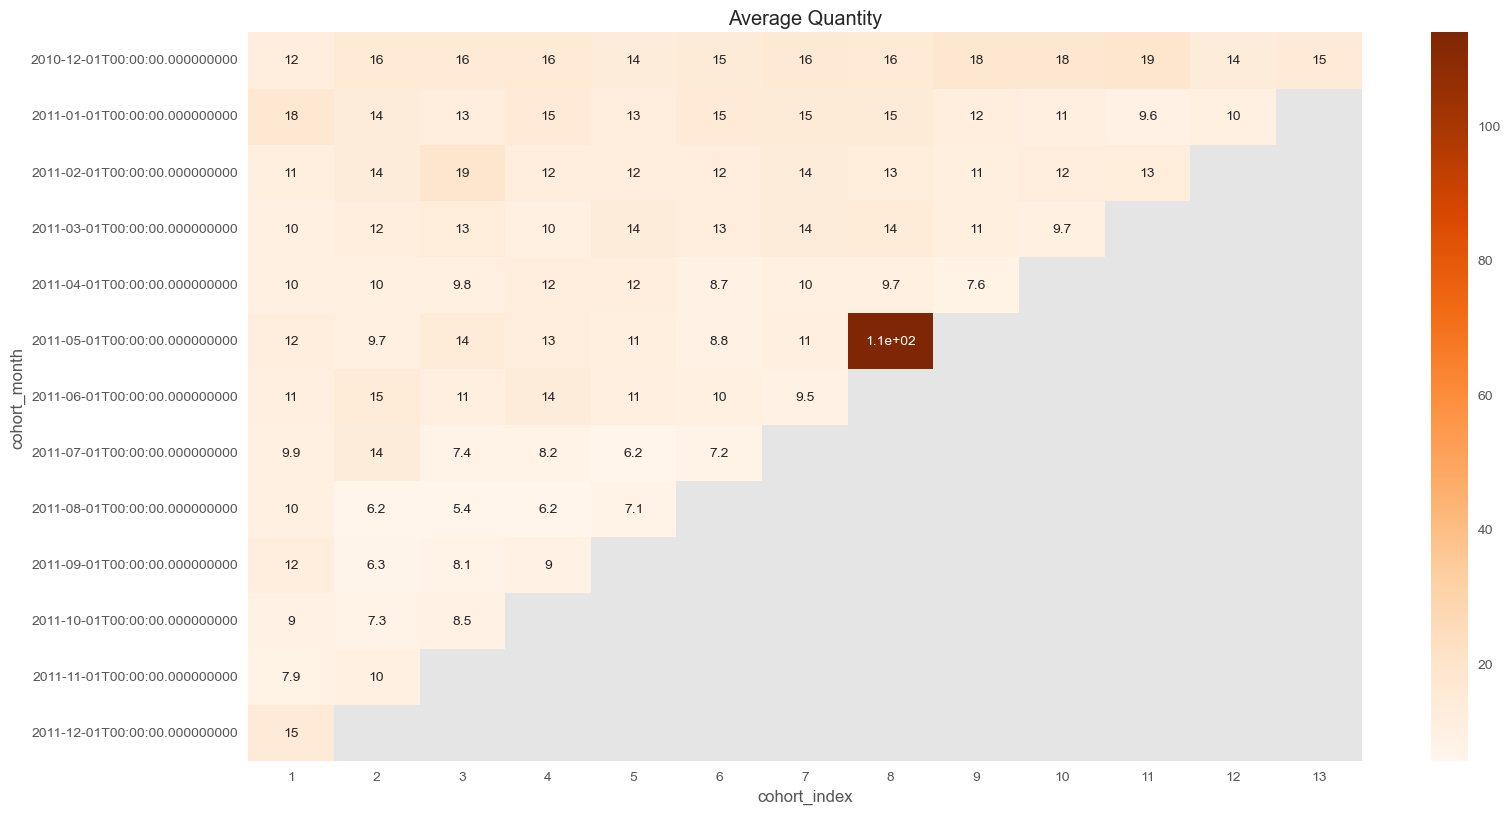

In [158]:
plt.figure(figsize = (16, 9))
plt.title('Average Quantity')
sns.heatmap(data=pivot_cohort2, annot=True, cmap="Oranges")
plt.show()

## Create the 3rd Cohort: Average Sales

**Pivot Cohort and Cohort Retention**

In [159]:
cohort3 = df_cohort.groupby(['cohort_month', 'cohort_index'])['total_price'].mean().reset_index()
cohort3.head()

,cohort_month,cohort_index,total_price
0,2010-12-01,1,22.221
1,2010-12-01,2,27.271
2,2010-12-01,3,26.860
3,2010-12-01,4,27.189
4,2010-12-01,5,21.192


In [160]:
pivot_cohort3 = cohort3.pivot(index='cohort_month', columns='cohort_index', values='total_price').round(1)
pivot_cohort3.head()

cohort_index,1,2,3,4,5,6,7,8,9,10,11,12,13
cohort_month,,,,,,,,,,,,,
2010-12-01,22.200,27.300,26.900,27.200,21.200,28.100,28.300,27.400,29.300,33.500,34.000,23.600,25.800
2011-01-01,26.900,25.100,21.000,31.200,22.500,26.300,25.200,25.500,19.100,22.300,19.700,19.800,NaN
2011-02-01,17.900,20.800,21.500,19.400,17.700,17.000,22.200,22.900,18.800,22.200,23.500,NaN,NaN
2011-03-01,17.600,21.100,22.700,18.000,21.100,19.000,22.000,20.000,16.800,13.200,NaN,NaN,NaN
2011-04-01,17.000,21.000,19.500,18.700,19.500,15.000,15.300,16.000,12.300,NaN,NaN,NaN,NaN


**Visualizing analysis of cohort 3**

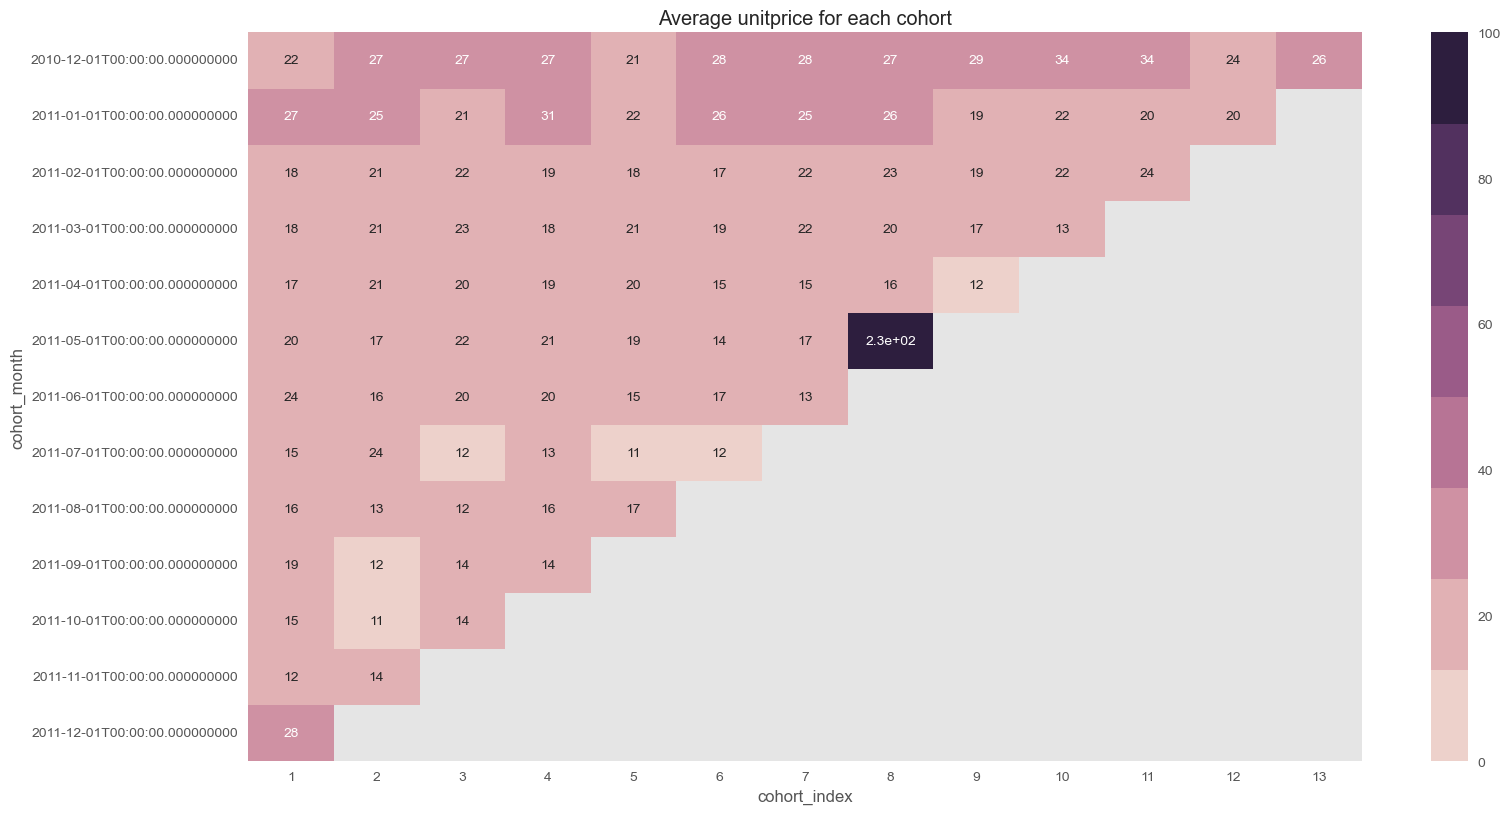

In [161]:
plt.figure(figsize = (16, 9))
plt.title('Average unitprice for each cohort')
sns.heatmap(data=pivot_cohort3 ,annot = True, vmin = 0.0, vmax =100,cmap=sns.cubehelix_palette(8))
plt.show()

# <p style="background-color:#1874CD; font-family:newtimeroman; color:#FFF9ED; font-size:130%; text-align:center; border-radius:10px 10px;">Conclusion</p>

<a id="8"></a>
<a href="#74" class="btn btn-primary btn-sm" role="button" aria-pressed="true" 
style="color:blue; background-color:#dfa8e4" data-toggle="popover">Table of Contents</a>

For e-commerce organizations, cohort analysis provides a tremendous opportunity to find out which customers are most valuable to their business. Cohort analysis is the best way to obtain answers to the following questions:

* How effective was a marketing campaign conducted in a given time frame?
* Has the strategy implemented to improve customers' conversion rates work?
* Should I focus more on retention rather than acquiring new customers?
* Are my customer nurturing strategies effective?
* Which marketing channels bring me the best results?
* Is there a seasonality pattern in customer behavior?